# 1. Import Dependencies

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable 

from prophet import Prophet
from prophet.diagnostics import cross_validation
from neuralprophet import NeuralProphet

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdate
import matplotlib.patheffects as PathEffects
import seaborn as sns

import pandas as pd
import datetime as dt
import requests

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr as PCC

from importlib import reload
import neural_network_classes
reload(neural_network_classes)
from neural_network_classes import LSTM, DARNN, HARHN

print("All libraries loaded")

WARNING - (py.warnings._showwarnmsg) - C:\Users\cpras\anaconda3\envs\GasPrice\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"



All libraries loaded


# 2. Download Data

In [2]:
def download_data(url, name='', usecols=None, sheet_name=1, header=2, plot=False): 
    global config
    
    r = requests.get(url)
    open('temp.xls', 'wb').write(r.content)
    df = pd.read_excel('temp.xls', sheet_name=sheet_name, header=header, usecols=usecols) 
    df = df[~df.isnull().any(axis=1)] # remove rows with any missing data
       
    num_data_points = len(df)
    
    df2 = df.iloc[[0, -1]]    
    date_range = "from " + str(df2.iloc[0,0]) + " to " + str(df2.iloc[1,0])
    print(date_range, str(num_data_points) + ' Data Points')
    
    data_dict = {}
    data_dict['data'] = df.rename(columns={df.keys()[0]: 'date', 
                            df.keys()[1]: name})
    data_dict['num elements'] = num_data_points
    data_dict['date range'] = date_range
    data_dict['name'] = df.keys()[1]
    
    if plot:
        fig = figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(data_dict['data']['date'], data_dict['data'][name], color=config["plots"]["color_actual"])
        plt.title(data_dict['name'] + ", " + data_dict['date range'] + ", " + str(data_dict['num elements']) + " Data Points")

        # Format the x axis
        locator = mdate.MonthLocator(interval=config["plots"]["xticks_interval"])
        fmt = mdate.DateFormatter('%Y-%m')
        X = plt.gca().xaxis
        X.set_major_locator(locator)
        # Specify formatter
        X.set_major_formatter(fmt)
        plt.xticks(rotation='vertical')
        plt.xlim([data_dict['data'].iloc[0,0], data_dict['data'].iloc[-1,0]])

        plt.grid(visible=None, which='major', axis='y', linestyle='--')
        plt.show()
         
    return data_dict

In [3]:
plot = False

## 2a. Seattle Gas Prices (targets)

In [4]:
seattle_gas_prices = download_data('https://www.eia.gov/dnav/pet/hist_xls/EMM_EPMRU_PTE_Y48SE_DPGw.xls', 
                                   name='gas price',
                                  plot=plot)

print(seattle_gas_prices['data'].head())

from 2003-05-26 00:00:00 to 2022-07-11 00:00:00 999 Data Points
        date  gas price
0 2003-05-26      1.534
1 2003-06-02      1.524
2 2003-06-09      1.522
3 2003-06-16      1.578
4 2003-06-23      1.580


## 2b. U.S. Crude Oil Stock Change (feature 1)

In [5]:
us_oil_stock = download_data('https://www.eia.gov/dnav/pet/hist_xls/MCRSCUS1m.xls',
                             name='oil stock exchange',
                             plot=plot)

print(us_oil_stock['data'].head())

from 1981-01-15 00:00:00 to 2022-04-15 00:00:00 496 Data Points
        date  oil stock exchange
0 1981-01-15               -1535
1 1981-02-15                7773
2 1981-03-15               19596
3 1981-04-15               17853
4 1981-05-15               12109


## 2c. U.S. Natural Gas Rotary Rigs in Operation (feature 2)

In [6]:
us_drilling_activity = download_data('https://www.eia.gov/dnav/pet/hist_xls/E_ERTRRG_XR0_NUS_Cm.xls',
                             name='drilling activity',
                             plot=plot)

print(us_drilling_activity['data'].head())

from 1987-08-15 00:00:00 to 2022-03-15 00:00:00 416 Data Points
          date  drilling activity
175 1987-08-15              352.0
176 1987-09-15              364.0
177 1987-10-15              377.0
178 1987-11-15              386.0
179 1987-12-15              403.0


## 2d. U.S. Natural Gas Production (feature 3)

In [7]:
us_gas_production = download_data('https://www.eia.gov/dnav/ng/hist_xls/N9050US2m.xls',
                             name='gas production',
                             plot=plot)

print(us_gas_production['data'].head())

from 1973-01-15 00:00:00 to 2022-04-15 00:00:00 592 Data Points
        date  gas production
0 1973-01-15         1948000
1 1973-02-15         1962000
2 1973-03-15         1907000
3 1973-04-15         1814000
4 1973-05-15         1898000


## 2e. U.S. Natural Gas Consumption (feature 4)

In [8]:
us_gas_consumption = download_data('https://www.eia.gov/dnav/ng/hist_xls/N9140US2m.xls',
                             name='gas consumption',
                             plot=plot)

print(us_gas_consumption['data'].head())

from 2001-01-15 00:00:00 to 2022-04-15 00:00:00 256 Data Points
        date  gas consumption
0 2001-01-15          2676998
1 2001-02-15          2309464
2 2001-03-15          2246633
3 2001-04-15          1807170
4 2001-05-15          1522382


## 2f. Underground Natural Gas Storage Capacity (feature 5)

In [9]:
us_gas_storage = download_data('https://www.eia.gov/dnav/ng/xls/NG_STOR_CAP_DCU_NUS_M.xls',
                             name='gas storage',
                               usecols='A:B',
                             plot=plot)

print(us_gas_storage['data'].head())

from 1989-01-15 00:00:00 to 2022-04-15 00:00:00 400 Data Points
        date  gas storage
0 1989-01-15      8119368
1 1989-02-15      8119368
2 1989-03-15      8119368
3 1989-04-15      8119368
4 1989-05-15      8119368


## 2g. U.S. Natural Gas Import Volumes (feature 6)

In [10]:
us_gas_import_volume = download_data('https://www.eia.gov/dnav/ng/xls/NG_MOVE_IMPC_S1_M.xls',
                             name='gas import volume',
                               usecols='A:B',
                               sheet_name=1,
                             plot=plot)

print(us_gas_import_volume['data'].tail())

from 1973-01-15 00:00:00 to 2022-04-15 00:00:00 592 Data Points
          date  gas import volume
587 2021-12-15             252626
588 2022-01-15             296179
589 2022-02-15             259389
590 2022-03-15             260642
591 2022-04-15             246576


## 2g. U.S. Natural Gas Import Prices (feature 7)

In [11]:
us_gas_import_price = download_data('https://www.eia.gov/dnav/ng/xls/NG_MOVE_IMPC_S1_M.xls',
                             name='gas import price',
                               usecols='A:B',
                               sheet_name=2,
                             plot=plot)

print(us_gas_import_price['data'].tail())

from 1989-01-15 00:00:00 to 2022-04-15 00:00:00 400 Data Points
          date  gas import price
395 2021-12-15              4.74
396 2022-01-15              6.87
397 2022-02-15              5.62
398 2022-03-15              4.67
399 2022-04-15              5.46


## 2h. Henry Hub Natural Gas Spot Price (feature 8)

In [12]:
hh_natural_gas_price = download_data('https://www.eia.gov/dnav/ng/hist_xls/RNGWHHDm.xls',
                             name='natural gas price',
                             plot=plot)

print(hh_natural_gas_price['data'].head())

from 1997-01-15 00:00:00 to 2022-06-15 00:00:00 306 Data Points
        date  natural gas price
0 1997-01-15               3.45
1 1997-02-15               2.15
2 1997-03-15               1.89
3 1997-04-15               2.03
4 1997-05-15               2.25


## 2i. Crude Oil Sport Price (feature 9)

In [13]:
us_crude_oil_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='crude oil price',
                                   usecols='A:B',
                                   sheet_name=1, 
                                   plot=plot)

print(us_crude_oil_price['data'].head())

from 1986-01-15 00:00:00 to 2022-06-15 00:00:00 438 Data Points
        date  crude oil price
0 1986-01-15            22.93
1 1986-02-15            15.46
2 1986-03-15            12.61
3 1986-04-15            12.84
4 1986-05-15            15.38


## 2j. Conventional Gasoline Price (feature 10)

In [14]:
us_gas_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='conventional gas price',
                                   usecols='A:B',
                                   sheet_name=2, 
                                   plot=plot)

print(us_gas_price['data'].head())

from 1986-06-15 00:00:00 to 2022-06-15 00:00:00 433 Data Points
        date  conventional gas price
0 1986-06-15                   0.420
1 1986-07-15                   0.340
2 1986-08-15                   0.426
3 1986-09-15                   0.420
4 1986-10-15                   0.410


## 2k. RBOB Gasoline Price (feature 11)

In [15]:
us_rbob_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='rbob gas price',
                                   usecols='A:B',
                                   sheet_name=3, 
                                   plot=plot)

print(us_rbob_price['data'].head())

from 2003-06-15 00:00:00 to 2022-06-15 00:00:00 229 Data Points
        date  rbob gas price
0 2003-06-15           1.072
1 2003-07-15           0.965
2 2003-08-15           1.315
3 2003-09-15           0.949
4 2003-10-15           0.996


## 2l. Heating Oil Price (feature 12)

In [16]:
us_heating_oil_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='heating oil price',
                                   usecols='A:B',
                                   sheet_name=4, 
                                   plot=plot)

print(us_heating_oil_price['data'].head())

from 1986-06-15 00:00:00 to 2022-06-15 00:00:00 433 Data Points
        date  heating oil price
0 1986-06-15              0.380
1 1986-07-15              0.334
2 1986-08-15              0.408
3 1986-09-15              0.402
4 1986-10-15              0.394


## 2m. Diesel Price (feature 13)

In [17]:
us_diesel_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='diesel price',
                                   usecols='A:B',
                                   sheet_name=5, 
                                   plot=plot)

print(us_diesel_price['data'].head())

from 2006-06-15 00:00:00 to 2022-06-15 00:00:00 193 Data Points
          date  diesel price
122 2006-06-15         2.091
123 2006-07-15         2.217
124 2006-08-15         2.247
125 2006-09-15         1.810
126 2006-10-15         1.794


## 2n. Kerosene Price (feature 14)

In [18]:
us_kerosene_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='kerosene price',
                                   usecols='A:B',
                                   sheet_name=6, 
                                   plot=plot)

print(us_kerosene_price['data'].tail())

from 1990-04-15 00:00:00 to 2022-06-15 00:00:00 387 Data Points
          date  kerosene price
382 2022-02-15           2.682
383 2022-03-15           3.495
384 2022-04-15           3.914
385 2022-05-15           3.902
386 2022-06-15           4.120


## 2o. Propane Price (feature 15)

In [19]:
us_propane_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='propane price',
                                   usecols='A:B',
                                   sheet_name=7, 
                                   plot=plot)

print(us_propane_price['data'].tail())

from 1992-06-15 00:00:00 to 2022-06-15 00:00:00 361 Data Points
          date  propane price
356 2022-02-15          1.283
357 2022-03-15          1.448
358 2022-04-15          1.302
359 2022-05-15          1.223
360 2022-06-15          1.219


# 3. Combine Feature and Target Data

In [20]:
# features
feature_list = [
    hh_natural_gas_price['data'],
    us_crude_oil_price['data'],
    us_gas_price['data'],
    us_rbob_price['data'],
    us_heating_oil_price['data'],
    us_diesel_price['data'],
    us_kerosene_price['data'],
    us_propane_price['data'],
    us_oil_stock['data'],
    us_drilling_activity['data'],
    us_gas_production['data'],
    us_gas_consumption['data'],
    us_gas_storage['data'],
    us_gas_import_volume['data'],
    us_gas_import_price['data']
]

# targets
targets = seattle_gas_prices['data'].set_index('date')

In [21]:
# reindex and concatenate features
kw = dict(method="time")
for i in range(0, len(feature_list)):
    if i > 1:
        feature = feature_list[i].set_index('date')
        feature = feature.reindex(feature.index.union(targets.index)).interpolate(**kw).reindex(targets.index)
        features = features.join(feature)
    else:
        feature = pd.DataFrame(feature_list[i]).set_index('date')
        features = feature.reindex(feature.index.union(targets.index)).interpolate(**kw).reindex(targets.index)  

# add week number (1-52) as a feature
features['week number'] = features.index.isocalendar().week
features['week number'] = features['week number'].astype(float)
    
# combine features and targets into one data frame
features_targets = features.join(targets)

# get rid of rows with any missing data
features_targets = features_targets[~features_targets.isnull().any(axis=1)]

# convert index datetimes to dates (exclude hour, minute, second)
features_targets.index = features_targets.index.date
features_targets

,crude oil price,conventional gas price,rbob gas price,heating oil price,diesel price,kerosene price,propane price,oil stock exchange,drilling activity,gas production,gas consumption,gas storage,gas import volume,gas import price,week number,gas price
2006-06-19,71.411333,2.087933,2.412600,1.926333,2.107800,2.090733,1.106067,-4598.933333,1376.400000,1.618895e+06,1.578593e+06,8.247523e+06,351139.000000,5.846000,25.0,3.067
2006-06-26,72.218667,2.128067,2.432900,1.928667,2.137200,2.107767,1.121933,-4744.066667,1377.100000,1.627353e+06,1.627092e+06,8.249157e+06,356466.000000,5.874000,26.0,3.027
2006-07-03,73.026000,2.168200,2.453200,1.931000,2.166600,2.124800,1.137800,-4889.200000,1377.800000,1.635812e+06,1.675591e+06,8.250790e+06,361793.000000,5.902000,27.0,3.004
2006-07-10,73.833333,2.208333,2.473500,1.933333,2.196000,2.141833,1.153667,-5034.333333,1378.500000,1.644271e+06,1.724091e+06,8.252423e+06,367120.000000,5.930000,28.0,3.032
2006-07-17,74.321613,2.224161,2.468774,1.938161,2.218935,2.152645,1.163258,-4727.161290,1381.451613,1.650682e+06,1.758278e+06,8.253590e+06,370540.935484,6.000968,29.0,3.018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-13,114.498710,4.065613,4.254774,4.262194,4.380323,4.105935,1.219258,-13469.000000,135.000000,3.134567e+06,2.357870e+06,9.258914e+06,246576.000000,5.460000,24.0,5.549
2022-06-20,114.840000,4.082000,4.270000,4.246000,4.362000,4.120000,1.219000,-13469.000000,135.000000,3.134567e+06,2.357870e+06,9.258914e+06,246576.000000,5.460000,25.0,5.518
2022-06-27,114.840000,4.082000,4.270000,4.246000,4.362000,4.120000,1.219000,-13469.000000,135.000000,3.134567e+06,2.357870e+06,9.258914e+06,246576.000000,5.460000,26.0,5.461
2022-07-04,114.840000,4.082000,4.270000,4.246000,4.362000,4.120000,1.219000,-13469.000000,135.000000,3.134567e+06,2.357870e+06,9.258914e+06,246576.000000,5.460000,27.0,5.405


# 4. Data Preprocessing

In [22]:
data = features_targets
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # training device
n_timeseries = data.shape[1] - 1 # input size
batch_size = 16
max_epochs = 250
target_name = 'gas price' # target variable name

timesteps = 4 # 10, lookback window
lstm_n_hidden = 64
lstm_n_layers = 2
darnn_n_enc_units = 64
darnn_n_dec_units = 64 # 64
harhn_n_enc_units = 64
harhn_n_dec_units = 64

## 4a. Incorporate Rolling Lookback Window

In [23]:
# Preallocate feature and target arrays
X_ = np.zeros((len(data), timesteps, data.shape[1]-1))
y_ = np.zeros((len(data), timesteps, 1))

In [24]:
for i, name in enumerate(list(data.columns[:-1])):
    for j in range(timesteps):
        X_[:, j, i] = data[name].shift(timesteps - j - 1).fillna(method="bfill")

In [25]:
for j in range(timesteps):
    y_[:, j, 0] = data[target_name].shift(timesteps - j - 1).fillna(method="bfill")

In [26]:
prediction_horizon = 1
target_ = data[target_name].shift(-prediction_horizon).fillna(method="ffill").values

## 4b. Build Training, Validation, and Testing Datasets

In [27]:
# Dataset indices
up_to_train_idx = int(data.shape[0]*0.70)
up_to_val_idx = int(data.shape[0]*0.85)

# Number of data points in each dataset
train_length = up_to_train_idx
val_length = up_to_val_idx - up_to_train_idx
test_length = data.shape[0] - train_length - val_length

print(train_length, val_length, test_length)

587 126 126


In [28]:
X = X_[timesteps:]
y = y_[timesteps:]
target = target_[timesteps:]

In [29]:
X_train = X[:train_length]
y_his_train = y[:train_length]
X_val = X[train_length:train_length+val_length]
y_his_val = y[train_length:train_length+val_length]
X_test = X[-val_length:]
y_his_test = y[-val_length:]
target_train = target[:train_length]
target_val = target[train_length:train_length+val_length]
target_test = target[-val_length:]

## 4c. Normalize Data

In [30]:
class Normalizer():
    def __init__(self):
        self.max = None
        self.min = None
        self.range = None

    def fit_transform(self, x):
        self.max = x.max(axis=0)
        self.min = x.min(axis=0)
        self.range = self.max - self.min
        normalized_x = (x - self.min)/self.range
        return normalized_x
    
    def transform(self, x):
        return (x - self.min)/self.range

    def inverse_transform(self, x):
        return (x*self.range) + self.min

In [31]:
x_scaler = Normalizer()
y_his_scaler = Normalizer()
target_scaler = Normalizer()

In [32]:
X_train = x_scaler.fit_transform(X_train)
X_val = x_scaler.transform(X_val)
X_test = x_scaler.transform(X_test)

y_his_train = y_his_scaler.fit_transform(y_his_train)
y_his_val = y_his_scaler.transform(y_his_val)
y_his_test = y_his_scaler.transform(y_his_test)

target_train = target_scaler.fit_transform(target_train)
target_val = target_scaler.transform(target_val)
target_test = target_scaler.transform(target_test)

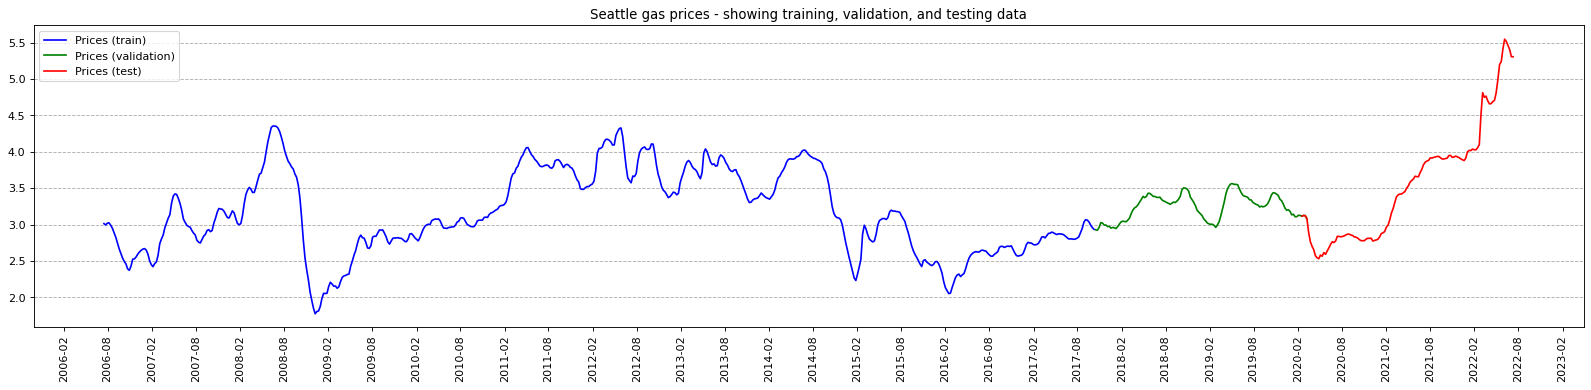

In [33]:
## Prepare data for plotting
data_date = features_targets.index.tolist()[timesteps:]
num_data_points = len(y)

to_plot_data_y_train = np.zeros(num_data_points)
to_plot_data_y_val = np.zeros(num_data_points)
to_plot_data_y_test = np.zeros(num_data_points)

to_plot_data_y_train[:train_length] = target_scaler.inverse_transform(target_train)
to_plot_data_y_val[train_length:train_length+val_length] = target_scaler.inverse_transform(target_val)
to_plot_data_y_test[-val_length:] = target_scaler.inverse_transform(target_test)

to_plot_data_y_train = np.where(to_plot_data_y_train == 0, None, to_plot_data_y_train)
to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)
to_plot_data_y_test = np.where(to_plot_data_y_test == 0, None, to_plot_data_y_test)

## Plotting
fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(data_date, to_plot_data_y_train, label="Prices (train)", color='blue')
plt.plot(data_date, to_plot_data_y_val, label="Prices (validation)", color='green')
plt.plot(data_date, to_plot_data_y_test, label="Prices (test)", color='red')

# Format the x axis
locator = mdate.MonthLocator(interval=6)
fmt = mdate.DateFormatter('%Y-%m')
X = plt.gca().xaxis
X.set_major_locator(locator) # error
# Specify formatter
X.set_major_formatter(fmt)
plt.xticks(rotation='vertical')
# plt.xlim([data_date[0], data_date[-1]])

plt.title("Seattle gas prices - showing training, validation, and testing data")
plt.grid(visible=None, which='major', axis='y', linestyle='--')
plt.legend()
plt.show()

## 4d. Build Torch Data Loaders

In [34]:
X_train_t = torch.Tensor(X_train)
X_val_t = torch.Tensor(X_val)
X_test_t = torch.Tensor(X_test)
y_his_train_t = torch.Tensor(y_his_train)
y_his_val_t = torch.Tensor(y_his_val)
y_his_test_t = torch.Tensor(y_his_test)
target_train_t = torch.Tensor(target_train)
target_val_t = torch.Tensor(target_val)
target_test_t = torch.Tensor(target_test)

In [35]:
data_train_loader = DataLoader(TensorDataset(X_train_t, y_his_train_t, target_train_t), shuffle=True, batch_size=batch_size)
data_val_loader = DataLoader(TensorDataset(X_val_t, y_his_val_t, target_val_t), shuffle=False, batch_size=batch_size)
data_test_loader = DataLoader(TensorDataset(X_test_t, y_his_test_t, target_test_t), shuffle=False, batch_size=batch_size)

# 5. Modeling Functions

## 5a. Early Stopping Callback

In [36]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

## 5b. Neural Network Training Function

In [37]:
def nn_train(model, model_name, epochs, data_train_loader, data_val_loader, opt, scheduler, target_scaler, plot=True):
    
    loss = nn.MSELoss()

    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=50, verbose=True, path=f'{model_name}.pt') 

    for i in range(epochs):
        mse_train = 0

        for batch_x, batch_y_h, batch_y in data_train_loader :

            batch_x = batch_x.to(device)  
            batch_y = batch_y.to(device)
            batch_y_h = batch_y_h.to(device)
            opt.zero_grad()
            
            if model_name == 'lstm':
                h, c = model.init_hidden_internal(batch_x.shape[0])
                y_pred, h, c = model(batch_x, batch_y_h, h, c)
            elif model_name == 'darnn':
                y_pred, alpha, beta = model(batch_x, batch_y_h)
            elif model_name == 'harhn':
                y_pred = model(batch_x, batch_y_h)

            y_pred = y_pred.squeeze(1)        
            l = loss(y_pred, batch_y)
            l.backward()
            mse_train += l.item()*batch_x.shape[0]
            opt.step()

        with torch.no_grad():
            mse_val = 0
            preds = []
            true = []
            for batch_x, batch_y_h, batch_y in data_val_loader:

                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)
                batch_y_h = batch_y_h.to(device)
                
                if model_name == 'lstm':
                    h, c = model.init_hidden_internal(batch_x.shape[0])
                    output, h, c = model(batch_x, batch_y_h, h, c)
                elif model_name == 'darnn':
                    output, alpha, beta = model(batch_x, batch_y_h)
                elif model_name == 'harhn':
                    output = model(batch_x, batch_y_h)

                output = output.squeeze(1)
                preds.append(output.detach().cpu().numpy())
                true.append(batch_y.detach().cpu().numpy())
                mse_val += loss(output, batch_y).item()*batch_x.shape[0]
                
        preds = np.concatenate(preds)
        true = np.concatenate(true)

        # Learning rate scheduler
        scheduler.step(mse_val/len(X_val_t))
        lr = opt.param_groups[0]['lr']

        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(mse_val/len(X_val_t), model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

        print("Iter: ", i, "train: ", (mse_train/len(X_train_t))**0.5, 
              "val: ", (mse_val/len(X_val_t))**0.5, 
              "LR: ", lr
             )
        if (plot == True) and (i % 10 == 0):
#             preds = preds*(target_train_max - target_train_min) + target_train_min
#             true = true*(target_train_max - target_train_min) + target_train_min
            preds = target_scaler.inverse_transform(preds)
            true = target_scaler.inverse_transform(true)
            mse = mean_squared_error(true, preds)
            mae = mean_absolute_error(true, preds)
            print("mse: ", mse, "mae: ", mae)
            plt.figure(figsize=(12, 6))
            plt.plot(preds, label='predicted')
            plt.plot(true, marker=".", markersize=10, color='black', linestyle = 'None', label='actual')
            plt.legend(loc="upper left")
            plt.title(f'Validation Results for Epoch {i}')
            plt.show()
    return

## 5c. Neural Network Test Set Evaluation Function

In [68]:
def nn_eval(model, model_name, data_test_loader, target_scaler):
    
    with torch.no_grad():
        mse_val = 0
        loss = nn.MSELoss()
        preds = []
        true = []
        alphas = []
        betas = []
        for batch_x, batch_y_h, batch_y in data_test_loader:
            h, c = lstm.init_hidden_internal(batch_x.shape[0])
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            batch_y_h = batch_y_h.to(device)
            
            if model_name == 'lstm':
                h, c = model.init_hidden_internal(batch_x.shape[0])
                output, h, c = model(batch_x, batch_y_h, h, c)
            elif model_name == 'darnn':
                output, alpha, beta = model(batch_x, batch_y_h)
                alphas.append(alpha.detach().cpu().numpy())
                betas.append(beta.detach().cpu().numpy())
            elif model_name == 'harhn':
                output = model(batch_x, batch_y_h)
                
            output = output.squeeze(1)
            
            preds.append(output.detach().cpu().numpy())
            true.append(batch_y.detach().cpu().numpy())
            mse_val += loss(torch.squeeze(output), batch_y).item()*batch_x.shape[0]
    preds = np.concatenate(preds)
    true = np.concatenate(true)
    if model_name == 'darnn':
        alphas = np.concatenate(alphas)
        betas = np.concatenate(betas)
    
    # De-normalize
    preds = target_scaler.inverse_transform(preds)
    true = target_scaler.inverse_transform(true)
    
    # Collect results
    mse = mean_squared_error(true, preds)
    mae = mean_absolute_error(true, preds)
    r2 = r2_score(true, preds)
    pcc, _ = PCC(true, preds)  
    err = true - preds
    
    # Time series plot
    plt.figure(figsize=(12, 6))
    plt.plot(preds, label='preds')
    plt.plot(true, marker=".", markersize=10, color='black', linestyle = 'None', label='actual')
    plt.legend(loc="upper left")
    plt.title(f'Test Results for {model_name.upper()} Model', fontsize=15)
    plt.xlabel('Samples', fontsize=12)
    plt.ylabel('Seattle Gas Price', fontsize=12)
    plt.show()
    
    # Scatter Plot
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.regplot(ax=ax, x=true, y=preds)
    ax.set_xlabel('True Values', fontsize=12)
    ax.set_ylabel('Predictions', fontsize=12)
    ax.set_title(f'Test Prediction Correlation \n R2 = {r2:.3f} \n PCC = {pcc:.3f}', fontsize=15)
    ax.set_aspect('equal', 'box')
    
    # Error Histogram
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.histplot(ax=ax, data=err, kde=True)
    ax.set_xlabel('Prediction Errors (U.S. $)', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title(f'Model Testing Prediction Errors \n MSE = {mse:.3f} \n MAE = {mae:.3f}', fontsize=15)
        
    if model_name == 'darnn':
        alphas = alphas.mean(axis=0)
        betas = betas.mean(axis=0).squeeze()
        # betas = betas[::-1]

        attn = np.zeros([len(alphas), len(betas)])
        for i in range(len(alphas)):
            for j in range(len(betas)):
                attn[i,j] = (alphas[i] + betas[j]) / 2
                
        max_attn = np.amax(attn)
        min_attn = np.amin(attn)
        min_range = min_attn + (0.25 * (max_attn - min_attn))
        max_range = max_attn - (0.25 * (max_attn - min_attn))

        # Attention Weights Heatmap
        fig, ax = plt.subplots(figsize=(10, 10))
        im = ax.imshow(attn, cmap='rainbow')
        cols = features_targets.columns[0:-1].tolist()
        ax.set_xticks(np.arange(len(betas)))
        ax.set_yticks(np.arange(len(alphas)))
        ax.set_xticklabels(["t-"+str(i) for i in np.arange(len(betas), 0, -1)])
        ax.set_yticklabels(cols)
        for i in range(len(cols)):
            for j in range(len(betas)):
                val = round(attn[i, j], 3)
                if val < max_range and val > min_range:
                    text = ax.text(j, i, val,
                                   ha="center", va="center", color="k")
                else:
                    text = ax.text(j, i, val,
                                   ha="center", va="center", color="w")
        ax.set_title(f"DA-RNN Attention Weights:\nImportance of Features and Timesteps")
        cbar = fig.colorbar(im, ax=ax, label='More Important \u2192')
        cbar.set_label(label='\n More Important \u2192',size='12')
        plt.show()
        
        # Feature Importance Bar Plot
        plt.figure(figsize=(8, 8))
        plt.title("Feature Importance\n(All Timesteps along Lookback Window)")
        plt.bar(range(len(cols)), alphas)
        plt.xticks(range(len(cols)), cols, rotation=90)
        plt.ylabel('Attention Weight')
    
    return mse, mae, r2, pcc, preds, true, alphas, betas

## 5d. Neural Network Future Prediction Function (i.e., forecast)

In [39]:
def nn_forecast(model, model_name, data, timesteps, n_timeseries, true, preds, x_scaler, y_his_scaler, target_scaler, plot_range=10):

    data = data.to_numpy()
    
    data_x_unseen = data[-timesteps:,:-1]
    y_hist_unseen = data[-timesteps:,-1]
    y_hist_unseen = np.expand_dims(y_hist_unseen, axis=1)
    
    data_x_unseen = x_scaler.transform(data_x_unseen)
    y_hist_unseen = y_his_scaler.transform(y_hist_unseen)
    
    x = torch.tensor(data_x_unseen).float().to(device).unsqueeze(0)
    y_hist = torch.tensor(y_hist_unseen).float().to(device).unsqueeze(0)

    model.eval()
    if model_name == 'lstm':
        h0, c0 = model.init_hidden_internal(x.shape[0])
        prediction, h, c = model(x, y_hist, h0, c0)
    elif model_name == 'darnn':
        prediction, alpha, beta = model(x, y_hist)
    elif model_name == 'harhn':
        prediction = model(x, y_hist)
        
    prediction = prediction.cpu().detach().numpy()

    # prepare plots

    to_plot_data_y_val = np.zeros(plot_range)
    to_plot_data_y_val_pred = np.zeros(plot_range)
    to_plot_data_y_test_pred = np.zeros(plot_range)

    to_plot_data_y_val[:plot_range-1] = true[-plot_range+1:]
    to_plot_data_y_val_pred[:plot_range-1] = preds[-plot_range+1:]

    to_plot_data_y_test_pred[plot_range-1] = target_scaler.inverse_transform(prediction)

    to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)
    to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)
    to_plot_data_y_test_pred = np.where(to_plot_data_y_test_pred == 0, None, to_plot_data_y_test_pred)

    # plot
    plot_date_test = data_date[-plot_range+1:]
    next_week = plot_date_test[-1] + dt.timedelta(days=7)
    plot_date_test.append(next_week)

    fig = figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(plot_date_test, to_plot_data_y_val, label="Actual prices", marker=".", markersize=10, color='black')
    plt.plot(plot_date_test, to_plot_data_y_val_pred, label="Past predicted prices", marker=".", markersize=10)
    plt.plot(plot_date_test, to_plot_data_y_test_pred, label="Predicted price for next week", marker=".", markersize=20, color='red')
    plt.title("Predicted Seattle gas price of the next week")
    plt.grid(visible=None, which='major', axis='y', linestyle='--')
    plt.legend()
    plt.show()

    print(f'{model_name.upper()} Predicted Seattle Gas Price of the next week: ${to_plot_data_y_test_pred[plot_range-1]:.2f}')
    
    return

# 6. Modeling

## 6a. Facebook Prophet

In [40]:
data = seattle_gas_prices
df = data['data'].set_axis(['ds', 'y'], axis=1, inplace=False)

n = NeuralProphet()
df_train, df_test = n.split_df(df=df, freq="W", valid_p=0.15)

params = {
    "changepoint_prior_scale": 0.25,
    "changepoint_range": 0.90,
    "interval_width": 0.95
}

# Train
m = Prophet(**params)
metrics =  m.fit(df_train)

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.9% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
22:47:47 - cmdstanpy - INFO - Chain [1] start processing
22:47:49 - cmdstanpy - INFO - Chain [1] done processing


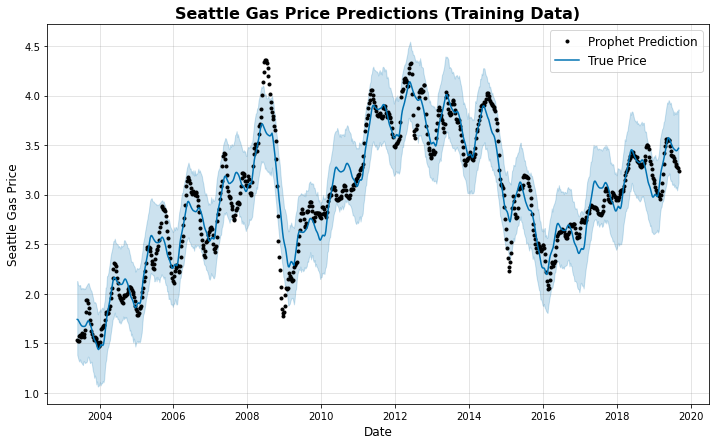

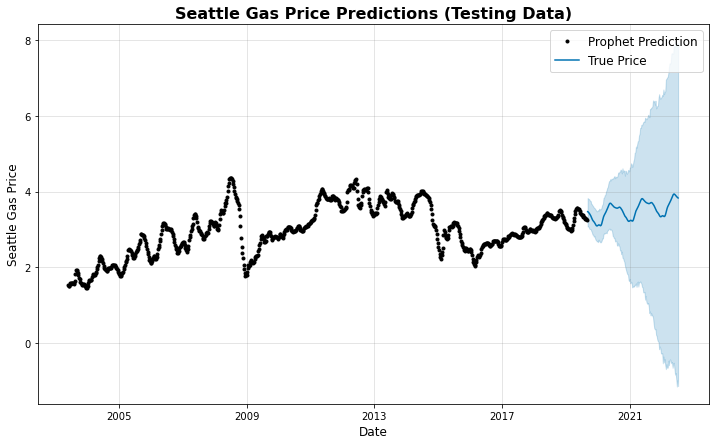

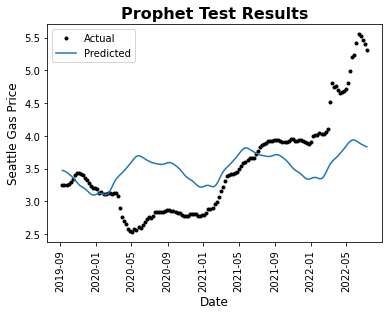

[0.42294241364464746, 0.5174360787890214, 0.22025914540502822, 0.5181583693643318]


In [41]:
# Evaluation
train_pred = m.predict(df_train)

fig1 = m.plot(train_pred)
ax = fig1.gca()
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Seattle Gas Price', fontsize=12)
ax.set_title("Seattle Gas Price Predictions (Training Data)", fontsize=16, fontweight="bold")
ax.legend(labels=['Prophet Prediction', 'True Price'], fontsize=12)

eval_pred = m.predict(df_test)

fig2 = m.plot(eval_pred)
ax = fig2.gca()
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Seattle Gas Price', fontsize=12)
ax.set_title("Seattle Gas Price Predictions (Testing Data)", fontsize=16, fontweight="bold")
ax.legend(labels=['Prophet Prediction', 'True Price'], fontsize=12)

fig3 = plt.figure()
y_true= df_test['y'].values
y_pred = eval_pred['yhat'].values
plt.plot(df_test['ds'], y_true, label='Actual', marker='.', linestyle='', color='k')
plt.plot(df_test['ds'], y_pred, label='Predicted')
plt.legend()
plt.xlabel('Date', fontsize=12)
plt.ylabel('Seattle Gas Price', fontsize=12)
plt.title("Prophet Test Results", fontsize=16, fontweight="bold")
plt.xticks(rotation='vertical')
plt.show()

# metrics
prophet_mse = mean_squared_error(y_true, y_pred)
prophet_mae = mean_absolute_error(y_true, y_pred)
prophet_r2 = r2_score(y_true, y_pred)
prophet_pcc = PCC(y_true, y_pred)[0]

print([prophet_mse, prophet_mae, prophet_r2, prophet_pcc])

22:47:53 - cmdstanpy - INFO - Chain [1] start processing
22:47:54 - cmdstanpy - INFO - Chain [1] done processing


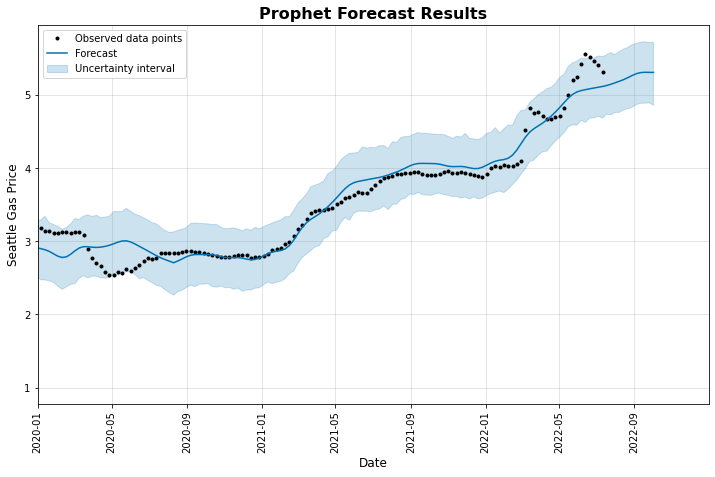

In [42]:
# Re-fit to all data
m = Prophet(**params)
metrics =  m.fit(df)

# Forecast
future = m.make_future_dataframe(periods=12, freq='W', include_history=True)
forecast = m.predict(future)

fig4 = m.plot(forecast)
ax = fig4.gca()
# setting x limit. date range to plot
ax.set_xlim(pd.to_datetime(['2020-01-01', '2022-12-31'])) 
plt.xlabel('Date', fontsize=12)
plt.ylabel('Seattle Gas Price', fontsize=12)
plt.title("Prophet Forecast Results", fontsize=16, fontweight="bold")
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

## 6b. Facebook Neural Prophet

### Training

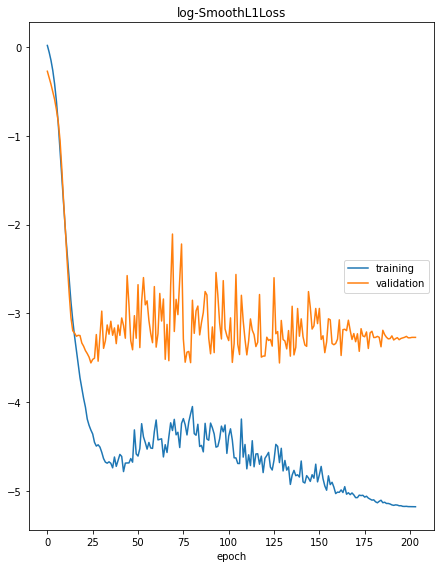

log-SmoothL1Loss
	training         	 (min:   -5.178, max:    0.018, cur:   -5.178)
	validation       	 (min:   -3.558, max:   -0.273, cur:   -3.270)


In [43]:
data = seattle_gas_prices
df = data['data'].set_axis(['ds', 'y'], axis=1, inplace=False)

# https://rdrr.io/github/AlbertoAlmuinha/neuralprophet/man/neural_prophet.html
params = {
    "changepoints_range": 0.90, 
}

model = NeuralProphet(**params)

df_train, df_test = model.split_df(df=df, freq="W", valid_p=0.15)

metrics =  model.fit(df_train, freq="W", validation_df=df_test, progress="plot")

### Evaluation

In [44]:
test_pred = model.predict(df_test)
test_metrics = model.test(df_test)

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.329% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.329% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.329% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMSE
1         0.038  0.577  0.699


INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.882% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.882% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.329% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.329% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


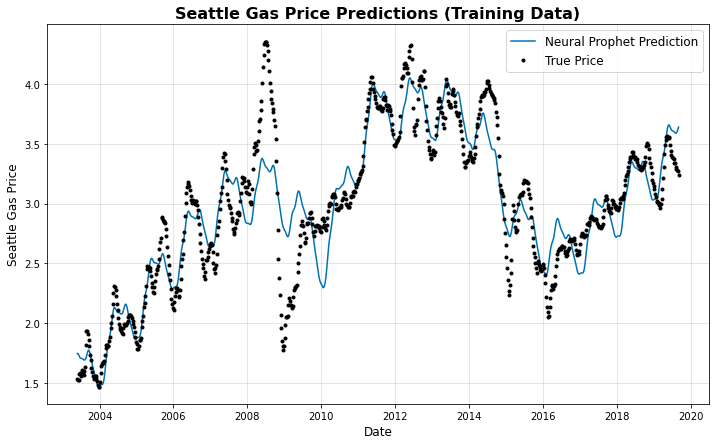

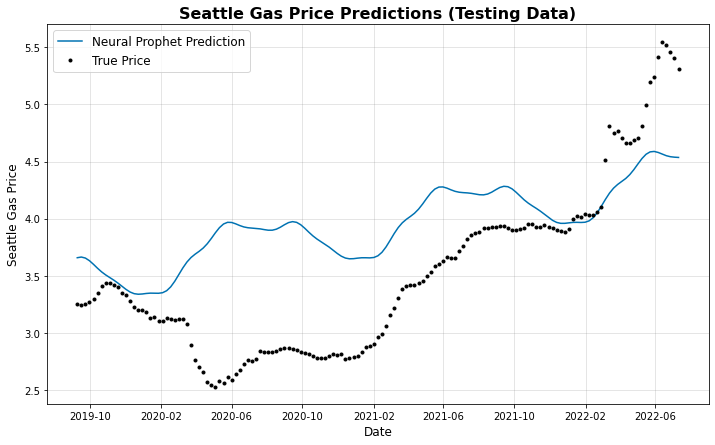

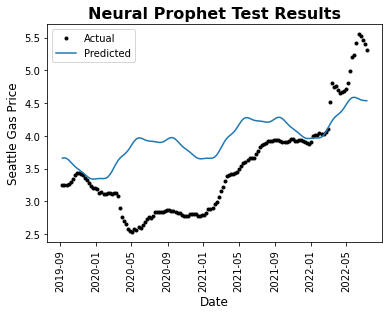

[0.4887884237856165, 0.5769258525643574, 0.09886478399173637, 0.7187044505941951]


In [45]:
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7), sharex=False)
# model.plot(model.predict(df), ax=ax1)
# ax1.set_xlabel('Date', fontsize=14)
# ax1.set_ylabel('Seattle Gas Price', fontsize=14)
# ax1.set_title("Seattle Gas Price Predictions (Train + Test)", fontsize=24, fontweight="bold")
# ax1.legend(labels=['NeuralProphet Prediction', 'True Price'], fontsize=12)

# model.plot(test_pred, xlabel='Date', ylabel='Seattle Gas Price', ax=ax2)
# ax2.set_xlabel('Date', fontsize=14)
# ax2.set_ylabel('Seattle Gas Price', fontsize=14)
# ax2.legend(labels=['NeuralProphet Prediction', 'True Price'], fontsize=12)

fig1 = model.plot(model.predict(df_train))
ax = fig1.gca()
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Seattle Gas Price', fontsize=12)
ax.set_title("Seattle Gas Price Predictions (Training Data)", fontsize=16, fontweight="bold")
ax.legend(labels=['Neural Prophet Prediction', 'True Price'], fontsize=12)

eval_pred = model.predict(df_test)

fig2 = model.plot(eval_pred)
ax = fig2.gca()
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Seattle Gas Price', fontsize=12)
ax.set_title("Seattle Gas Price Predictions (Testing Data)", fontsize=16, fontweight="bold")
ax.legend(labels=['Neural Prophet Prediction', 'True Price'], fontsize=12)

fig3 = plt.figure()
y_true = test_pred['y'].values
y_pred = test_pred['yhat1'].values
plt.plot(df_test['ds'], y_true, label='Actual', marker='.', linestyle='', color='k')
plt.plot(df_test['ds'], y_pred, label='Predicted')
plt.legend()
plt.xlabel('Date', fontsize=12)
plt.ylabel('Seattle Gas Price', fontsize=12)
plt.title("Neural Prophet Test Results", fontsize=16, fontweight="bold")
plt.xticks(rotation='vertical')
plt.show()

# metrics
nprophet_mse = mean_squared_error(y_true, y_pred)
nprophet_mae = mean_absolute_error(y_true, y_pred)
nprophet_r2 = r2_score(y_true, y_pred)
nprophet_pcc = PCC(y_true, y_pred)[0]

print([nprophet_mse, nprophet_mae, nprophet_r2, nprophet_pcc])

### Forecasting

In [46]:
model2 = NeuralProphet(**params)
metrics_train2 = model2.fit(df=df, freq="W")

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.9% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 194


  0%|          | 0/126 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.46E-02, min: 9.64E-01


  0%|          | 0/126 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.12E-01, min: 2.21E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.02E-01
Epoch[194/194]: 100%|████████| 194/194 [00:25<00:00,  7.70it/s, SmoothL1Loss=0.00778, MAE=0.234, RMSE=0.311, RegLoss=0]


In [47]:
# fig = model.plot(model2.predict(df))
# fig, ax = plt.subplots(figsize=(15, 7))
# model.plot(model.predict(df), ax=ax)
# # ax.set_xlabel('Date', fontsize=14)
# # ax.set_ylabel('Seattle Gas Price', fontsize=14)
# # ax.set_title("Seattle Gas Price Predictions \n (with model re-trained on all available data)", fontsize=24, fontweight="bold")
# ax.legend(labels=['NeuralProphet Prediction', 'True Price'], fontsize=12)

In [48]:
future = model2.make_future_dataframe(df, periods=12, n_historic_predictions=96)
forecast = model2.predict(future)

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.9% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
WARNING - (py.warnings._showwarnmsg) - C:\Users\cpras\anaconda3\envs\GasPrice\lib\site-packages\neuralprophet\forecaster.py:2060: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(future_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.148% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.148% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
WARNING - (py.warnings._showwarnmsg) - C:\Users\cpras\anaconda3\envs\GasPrice\lib\site-packages\neuralprophet\forecaster.py:1406: FutureWarning: T

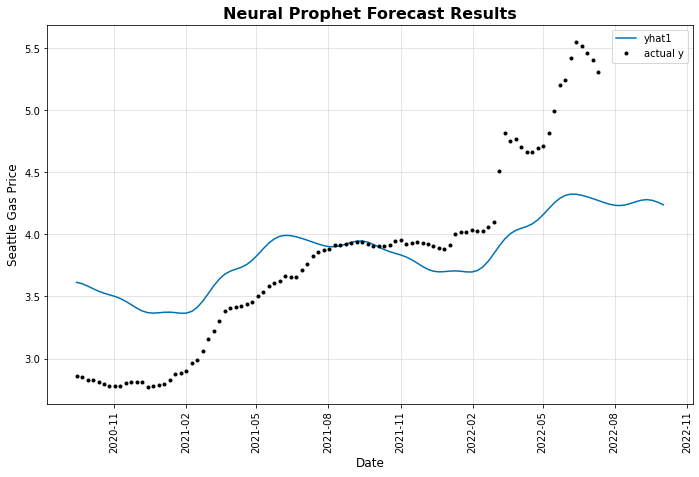

In [49]:
fig = model2.plot(forecast)
ax.legend(labels=['NeuralProphet Prediction', 'True Price'], fontsize=12)

# setting x limit. date range to plot
ax.set_xlim(pd.to_datetime(['2020-01-01', '2022-12-31'])) 
plt.xlabel('Date', fontsize=12)
plt.ylabel('Seattle Gas Price', fontsize=12)
plt.title("Neural Prophet Forecast Results", fontsize=16, fontweight="bold")
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

## 6c. Neural Network (LSTM)

### Training

In [50]:
lstm = LSTM(num_classes=1, input_size=n_timeseries+1, hidden_size=lstm_n_hidden, num_layers=lstm_n_layers, # hidden=64, layers=2
             seq_length=timesteps, device=device, dropout=0.2)
model_name = 'lstm'
lstm_opt = torch.optim.AdamW(lstm.parameters(), lr=0.01)
lstm_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=lstm_opt, patience=15)

Validation loss decreased (inf --> 0.009015).  Saving model ...
Iter:  0 train:  0.1669901387697911 val:  0.09494597638485497 LR:  0.01
mse:  0.060052235 mae:  0.21400902


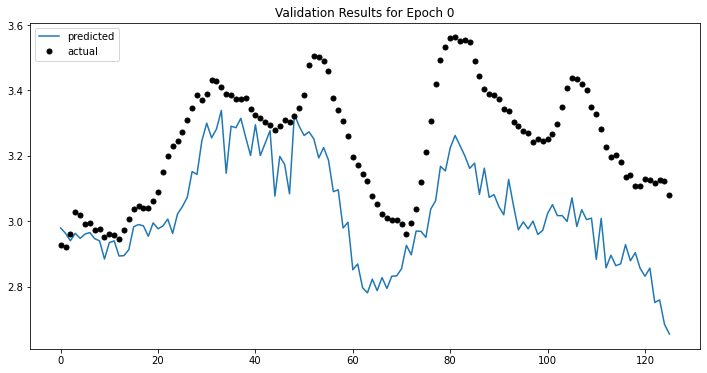

EarlyStopping counter: 1 out of 50
Iter:  1 train:  0.06325571054819155 val:  0.14370519790238426 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  2 train:  0.05130963766740096 val:  0.11206541582786482 LR:  0.01
EarlyStopping counter: 3 out of 50
Iter:  3 train:  0.04978037825883357 val:  0.10887927469041868 LR:  0.01
Validation loss decreased (0.009015 --> 0.007186).  Saving model ...
Iter:  4 train:  0.04727705123260927 val:  0.08477114045153476 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  5 train:  0.04494524867658406 val:  0.14259885559284935 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  6 train:  0.05251545322918514 val:  0.11871687691358322 LR:  0.01
EarlyStopping counter: 3 out of 50
Iter:  7 train:  0.042585364346868 val:  0.09244859450211383 LR:  0.01
EarlyStopping counter: 4 out of 50
Iter:  8 train:  0.04202851757782681 val:  0.10546353416676268 LR:  0.01
EarlyStopping counter: 5 out of 50
Iter:  9 train:  0.057088359310496474 val:  0.09655914770849318 LR:  

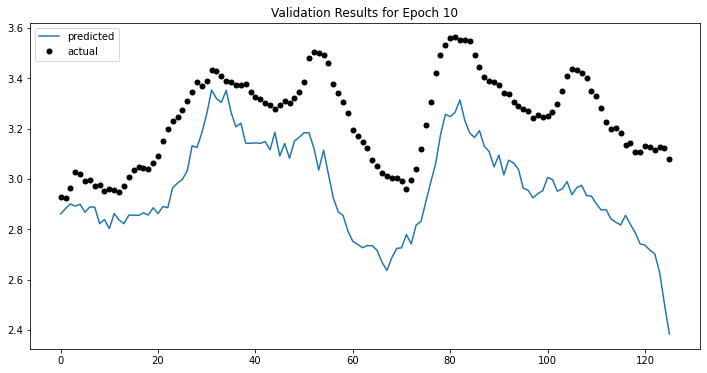

Validation loss decreased (0.007186 --> 0.001911).  Saving model ...
Iter:  11 train:  0.0429866041911584 val:  0.04371863550115677 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  12 train:  0.040661815717035706 val:  0.09448469203147579 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  13 train:  0.03803025367970903 val:  0.08287391798523218 LR:  0.01
EarlyStopping counter: 3 out of 50
Iter:  14 train:  0.04182601819313682 val:  0.11018129881178482 LR:  0.01
EarlyStopping counter: 4 out of 50
Iter:  15 train:  0.03563879945154317 val:  0.08184212294175608 LR:  0.01
EarlyStopping counter: 5 out of 50
Iter:  16 train:  0.03377547621317762 val:  0.07352618309654725 LR:  0.01
EarlyStopping counter: 6 out of 50
Iter:  17 train:  0.038947422492177426 val:  0.0941377747438448 LR:  0.01
EarlyStopping counter: 7 out of 50
Iter:  18 train:  0.0328088534965926 val:  0.08130051818706396 LR:  0.01
EarlyStopping counter: 8 out of 50
Iter:  19 train:  0.031267585729870796 val:  0.0719078524426

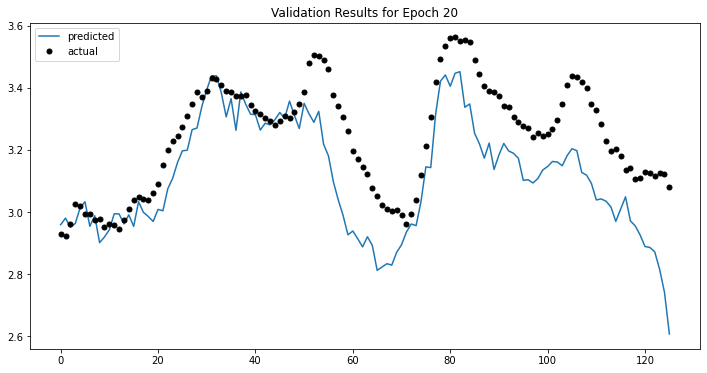

EarlyStopping counter: 10 out of 50
Iter:  21 train:  0.03539781636705418 val:  0.09320259486829932 LR:  0.01
EarlyStopping counter: 11 out of 50
Iter:  22 train:  0.03622590193947962 val:  0.048044251688662665 LR:  0.01
EarlyStopping counter: 12 out of 50
Iter:  23 train:  0.03305833333071508 val:  0.0490424088255641 LR:  0.01
EarlyStopping counter: 13 out of 50
Iter:  24 train:  0.02911123845336526 val:  0.05653772758343848 LR:  0.01
EarlyStopping counter: 14 out of 50
Iter:  25 train:  0.032783272644729626 val:  0.07234687880257204 LR:  0.01
EarlyStopping counter: 15 out of 50
Iter:  26 train:  0.04308404723174036 val:  0.05796414971237342 LR:  0.01
EarlyStopping counter: 16 out of 50
Iter:  27 train:  0.029545012854401444 val:  0.08159299877861007 LR:  0.001
EarlyStopping counter: 17 out of 50
Iter:  28 train:  0.027212923666940263 val:  0.06159471509811827 LR:  0.001
EarlyStopping counter: 18 out of 50
Iter:  29 train:  0.02365941289526897 val:  0.059428849091928145 LR:  0.001
Ear

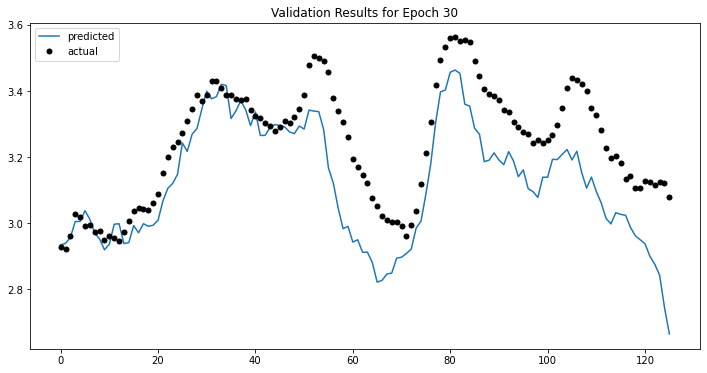

EarlyStopping counter: 20 out of 50
Iter:  31 train:  0.024200115820292783 val:  0.06338504486580945 LR:  0.001
EarlyStopping counter: 21 out of 50
Iter:  32 train:  0.022882209492070538 val:  0.058645056234985386 LR:  0.001
EarlyStopping counter: 22 out of 50
Iter:  33 train:  0.023056641832447468 val:  0.05734869718211308 LR:  0.001
EarlyStopping counter: 23 out of 50
Iter:  34 train:  0.022339656618680082 val:  0.062492934395389145 LR:  0.001
EarlyStopping counter: 24 out of 50
Iter:  35 train:  0.023099372708014064 val:  0.06413856195574359 LR:  0.001
EarlyStopping counter: 25 out of 50
Iter:  36 train:  0.022656319783335554 val:  0.05889473144144018 LR:  0.001
EarlyStopping counter: 26 out of 50
Iter:  37 train:  0.023226596311491154 val:  0.057778135907052705 LR:  0.001
EarlyStopping counter: 27 out of 50
Iter:  38 train:  0.023098237924680038 val:  0.05793446018874841 LR:  0.001
EarlyStopping counter: 28 out of 50
Iter:  39 train:  0.02276535065264838 val:  0.0625168079350236 LR

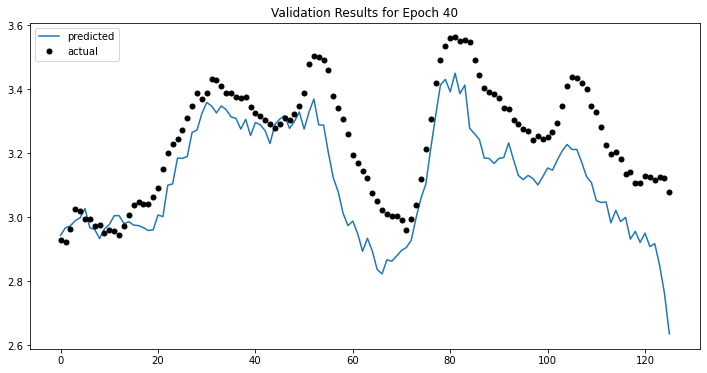

EarlyStopping counter: 30 out of 50
Iter:  41 train:  0.022590822224161942 val:  0.05567303069145198 LR:  0.001
EarlyStopping counter: 31 out of 50
Iter:  42 train:  0.023087919310058096 val:  0.05605106063469259 LR:  0.001
EarlyStopping counter: 32 out of 50
Iter:  43 train:  0.023282809830365202 val:  0.05948092119241043 LR:  0.0001
EarlyStopping counter: 33 out of 50
Iter:  44 train:  0.021279109158745927 val:  0.056164205804102404 LR:  0.0001
EarlyStopping counter: 34 out of 50
Iter:  45 train:  0.021827306714898957 val:  0.05461996418169222 LR:  0.0001
EarlyStopping counter: 35 out of 50
Iter:  46 train:  0.020773233288271242 val:  0.05726254455710866 LR:  0.0001
EarlyStopping counter: 36 out of 50
Iter:  47 train:  0.021305772172417164 val:  0.055085522810445146 LR:  0.0001
EarlyStopping counter: 37 out of 50
Iter:  48 train:  0.02129720764764093 val:  0.056622058470447725 LR:  0.0001
EarlyStopping counter: 38 out of 50
Iter:  49 train:  0.021636504230340088 val:  0.0546435919660

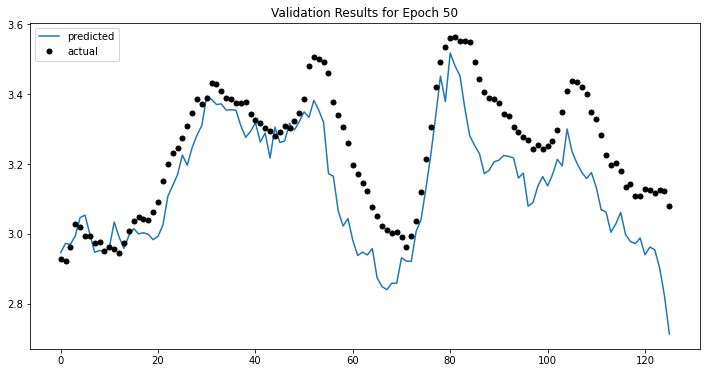

EarlyStopping counter: 40 out of 50
Iter:  51 train:  0.021382402988827817 val:  0.05458563631673669 LR:  0.0001
EarlyStopping counter: 41 out of 50
Iter:  52 train:  0.021510847319921367 val:  0.05623919268043148 LR:  0.0001
EarlyStopping counter: 42 out of 50
Iter:  53 train:  0.0214022578921512 val:  0.05415985229589924 LR:  0.0001
EarlyStopping counter: 43 out of 50
Iter:  54 train:  0.02067025447909024 val:  0.05483332142385125 LR:  0.0001
EarlyStopping counter: 44 out of 50
Iter:  55 train:  0.021634454161912033 val:  0.05429051609166947 LR:  0.0001
EarlyStopping counter: 45 out of 50
Iter:  56 train:  0.020825648860921003 val:  0.05412674044292432 LR:  0.0001
EarlyStopping counter: 46 out of 50
Iter:  57 train:  0.021238091614800177 val:  0.05300592640890853 LR:  0.0001
EarlyStopping counter: 47 out of 50
Iter:  58 train:  0.021036923429617296 val:  0.05481110356349036 LR:  0.0001
EarlyStopping counter: 48 out of 50
Iter:  59 train:  0.021981269696141302 val:  0.0515929233558280

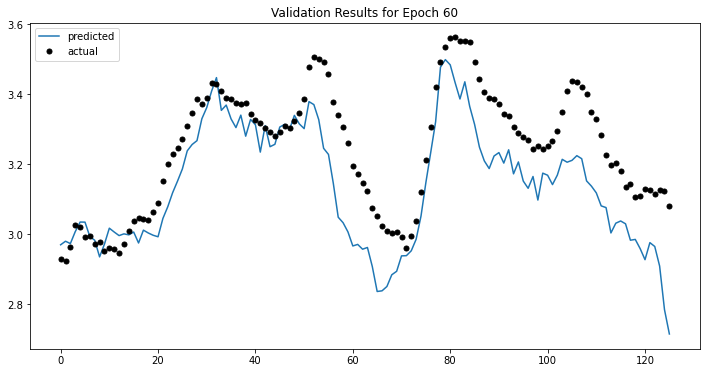

EarlyStopping counter: 50 out of 50
Early stopping


In [51]:
nn_train(model=lstm, 
         model_name=model_name, 
         epochs=max_epochs, 
         data_train_loader=data_train_loader, 
         data_val_loader=data_val_loader, 
         opt=lstm_opt, 
         scheduler=lstm_scheduler,
         target_scaler=target_scaler,
         plot=True)

### Evaluation

In [52]:
lstm.load_state_dict(torch.load(f"{model_name}.pt"))

<All keys matched successfully>

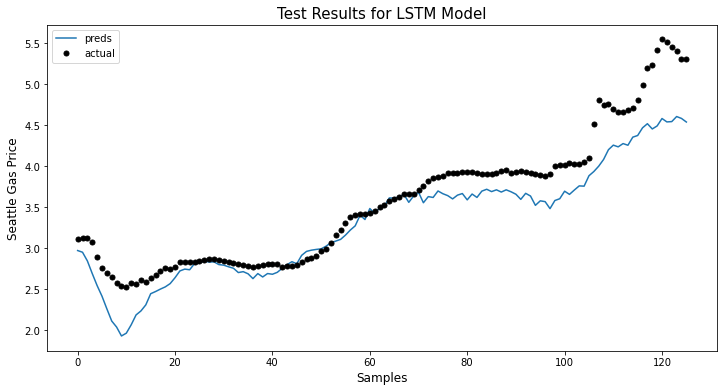

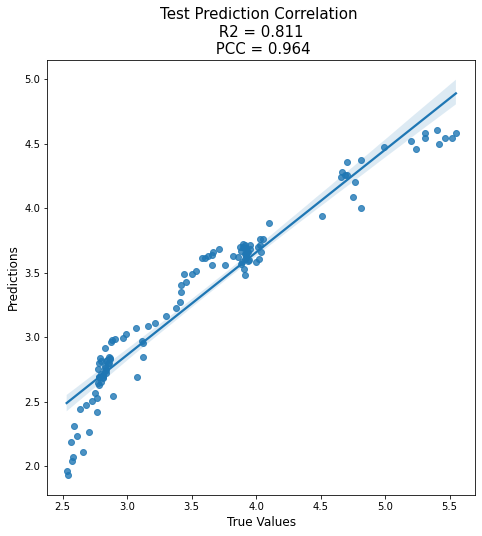

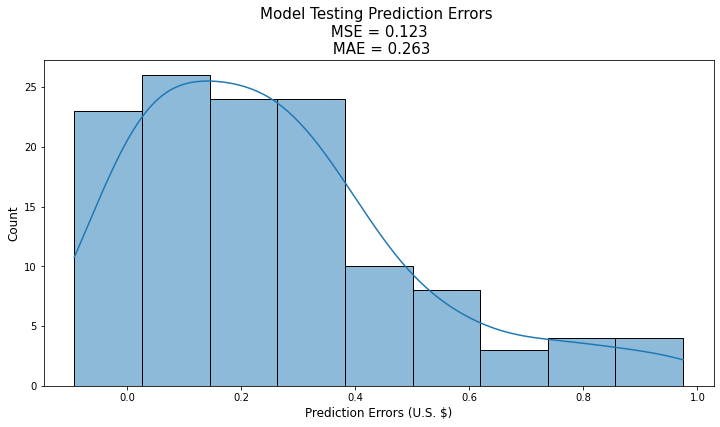

In [53]:
lstm_mse, lstm_mae, lstm_r2, lstm_pcc, lstm_preds, lstm_true, _, _ = nn_eval(model=lstm, 
                                                                             model_name='lstm', 
                                                                             data_test_loader=data_test_loader, 
                                                                             target_scaler=target_scaler)

### Forecasting

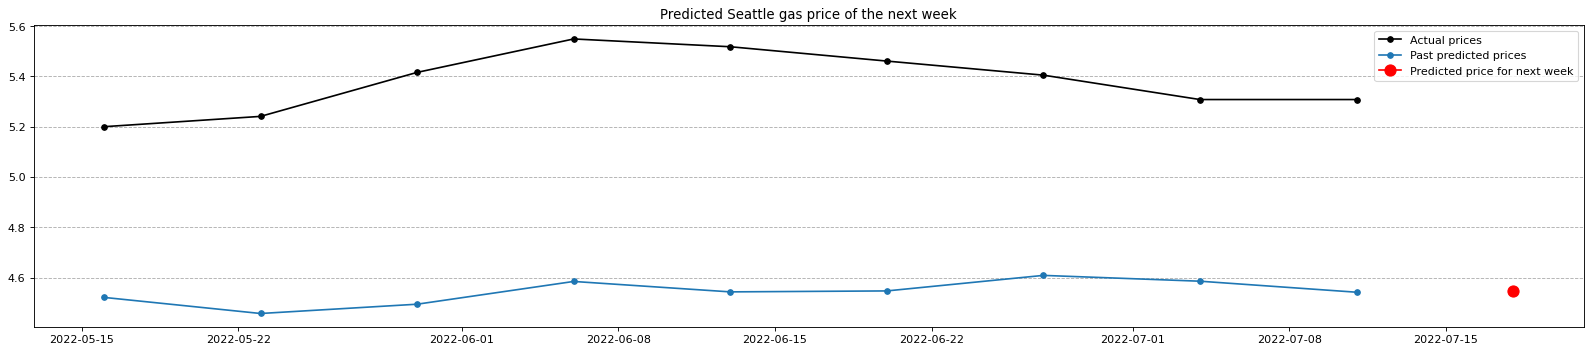

LSTM Predicted Seattle Gas Price of the next week: $4.55


In [54]:
nn_forecast(model = lstm,
            model_name = 'lstm', 
            data = features_targets, 
            timesteps = timesteps, 
            n_timeseries = n_timeseries, 
            true = lstm_true, 
            preds = lstm_preds,
            x_scaler = x_scaler, 
            y_his_scaler = y_his_scaler, 
            target_scaler = target_scaler, 
            plot_range=10
           )

## 6d. Dual-Stage Attention-Based Recurrent Neural Network (DA-RNN)

### Training

In [55]:
darnn = DARNN(N=X_train.shape[2], M=darnn_n_enc_units, P=darnn_n_dec_units, # 1) M=64, P=16
              T=X_train.shape[1], device=device).to(device) 
model_name = 'darnn'
darnn_opt = torch.optim.AdamW(darnn.parameters(), lr=0.01)
darnn_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=darnn_opt, patience=15)

Validation loss decreased (inf --> 0.044888).  Saving model ...
Iter:  0 train:  0.21881749436080547 val:  0.2118668770508982 LR:  0.01
mse:  0.2990213 mae:  0.5222814


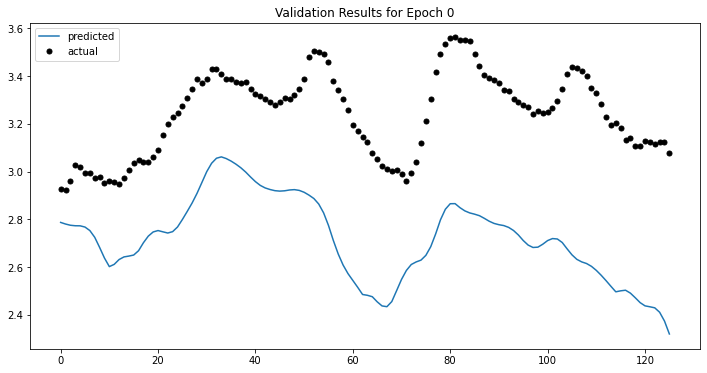

Validation loss decreased (0.044888 --> 0.033386).  Saving model ...
Iter:  1 train:  0.07071798902704017 val:  0.18271741277308673 LR:  0.01
Validation loss decreased (0.033386 --> 0.016987).  Saving model ...
Iter:  2 train:  0.06008618623697236 val:  0.13033544092476484 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  3 train:  0.056377656937599906 val:  0.13972893430641808 LR:  0.01
Validation loss decreased (0.016987 --> 0.008265).  Saving model ...
Iter:  4 train:  0.054787581925555044 val:  0.09091073338156636 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  5 train:  0.05462374251873818 val:  0.13778655007507087 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  6 train:  0.05225037672461046 val:  0.14429914607521402 LR:  0.01
EarlyStopping counter: 3 out of 50
Iter:  7 train:  0.050141672116671074 val:  0.1332678556520221 LR:  0.01
EarlyStopping counter: 4 out of 50
Iter:  8 train:  0.04520692198634094 val:  0.11712047600372394 LR:  0.01
EarlyStopping counter: 5 out of 

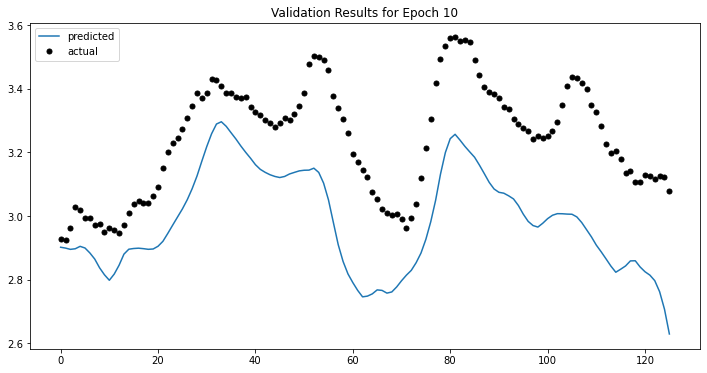

EarlyStopping counter: 7 out of 50
Iter:  11 train:  0.03833881019551252 val:  0.09295409379182536 LR:  0.01
Validation loss decreased (0.008265 --> 0.004108).  Saving model ...
Iter:  12 train:  0.03110658227923277 val:  0.06409598553754214 LR:  0.01
Validation loss decreased (0.004108 --> 0.000645).  Saving model ...
Iter:  13 train:  0.028301956333515094 val:  0.02538840180952931 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  14 train:  0.030689507756978634 val:  0.05064746592136251 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  15 train:  0.02028436822078135 val:  0.04517611558825139 LR:  0.01
EarlyStopping counter: 3 out of 50
Iter:  16 train:  0.017964904515605663 val:  0.031228012016893795 LR:  0.01
EarlyStopping counter: 4 out of 50
Iter:  17 train:  0.02174557852947026 val:  0.026215890431125176 LR:  0.01
Validation loss decreased (0.000645 --> 0.000440).  Saving model ...
Iter:  18 train:  0.01871068644294054 val:  0.020979773743668755 LR:  0.01
EarlyStopping counte

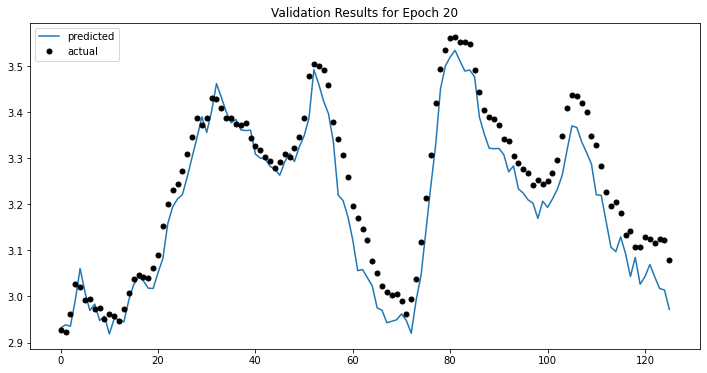

Validation loss decreased (0.000440 --> 0.000378).  Saving model ...
Iter:  21 train:  0.016727892955080308 val:  0.019448189483268093 LR:  0.01
Validation loss decreased (0.000378 --> 0.000363).  Saving model ...
Iter:  22 train:  0.018293907369827715 val:  0.01905764108705463 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  23 train:  0.0204171659632386 val:  0.05060629777423878 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  24 train:  0.0224166453885827 val:  0.021458213392962663 LR:  0.01
EarlyStopping counter: 3 out of 50
Iter:  25 train:  0.018948712713500952 val:  0.03192433675276072 LR:  0.01
EarlyStopping counter: 4 out of 50
Iter:  26 train:  0.01609694785001024 val:  0.044791320633304106 LR:  0.01
EarlyStopping counter: 5 out of 50
Iter:  27 train:  0.01813149047457279 val:  0.04301902613298939 LR:  0.01
EarlyStopping counter: 6 out of 50
Iter:  28 train:  0.020767713999572432 val:  0.023885181198142223 LR:  0.01
EarlyStopping counter: 7 out of 50
Iter:  29 train:  0

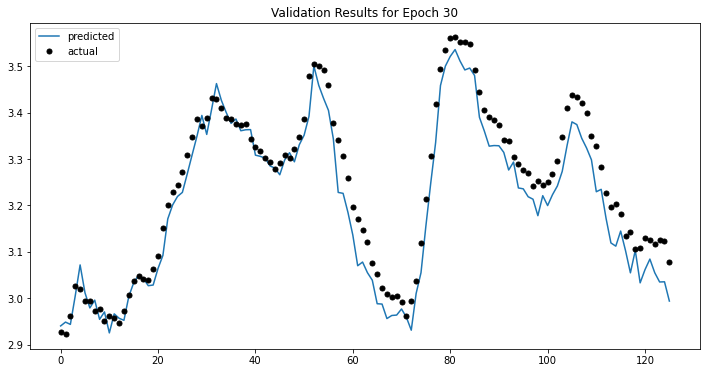

EarlyStopping counter: 1 out of 50
Iter:  31 train:  0.016536871015225867 val:  0.029542653765115424 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  32 train:  0.01691025158250767 val:  0.0236378089162413 LR:  0.01
EarlyStopping counter: 3 out of 50
Iter:  33 train:  0.01824406667708125 val:  0.03705306115475505 LR:  0.01
EarlyStopping counter: 4 out of 50
Iter:  34 train:  0.01916734313418334 val:  0.03995169457929931 LR:  0.01
EarlyStopping counter: 5 out of 50
Iter:  35 train:  0.02302560529848583 val:  0.04055497962055722 LR:  0.01
Validation loss decreased (0.000351 --> 0.000203).  Saving model ...
Iter:  36 train:  0.01718789455321526 val:  0.014243274926454831 LR:  0.01
Validation loss decreased (0.000203 --> 0.000164).  Saving model ...
Iter:  37 train:  0.01659447356328086 val:  0.012814753468880245 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  38 train:  0.019079073774773175 val:  0.01900510945807655 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  39 train:  0.0

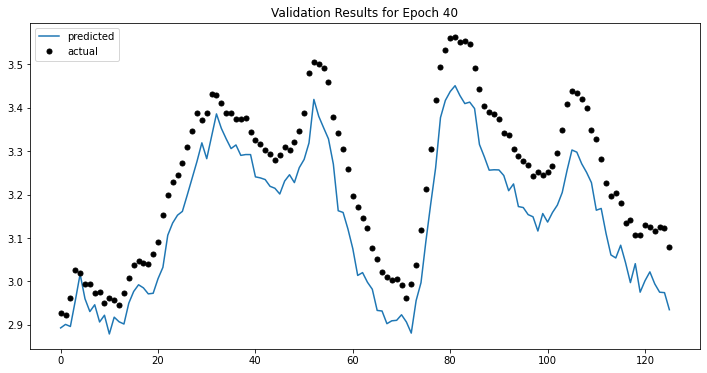

EarlyStopping counter: 4 out of 50
Iter:  41 train:  0.01873053086114871 val:  0.024856026100046565 LR:  0.01
EarlyStopping counter: 5 out of 50
Iter:  42 train:  0.016535404842800867 val:  0.043133660842947535 LR:  0.01
EarlyStopping counter: 6 out of 50
Iter:  43 train:  0.0174037548604516 val:  0.03309531807314235 LR:  0.01
EarlyStopping counter: 7 out of 50
Iter:  44 train:  0.022858093302410724 val:  0.04238197643622327 LR:  0.01
EarlyStopping counter: 8 out of 50
Iter:  45 train:  0.015614082795827855 val:  0.016592633092576397 LR:  0.01
EarlyStopping counter: 9 out of 50
Iter:  46 train:  0.0170212786824758 val:  0.022865933537870586 LR:  0.01
EarlyStopping counter: 10 out of 50
Iter:  47 train:  0.018547350520239345 val:  0.036728677859678774 LR:  0.01
EarlyStopping counter: 11 out of 50
Iter:  48 train:  0.020913528745007133 val:  0.033687505354712564 LR:  0.01
EarlyStopping counter: 12 out of 50
Iter:  49 train:  0.017986728850262992 val:  0.041672879632883554 LR:  0.01
Early

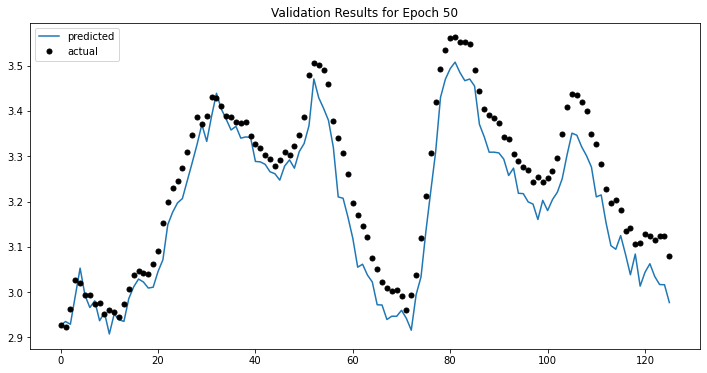

EarlyStopping counter: 14 out of 50
Iter:  51 train:  0.017425077450968413 val:  0.03261602122683017 LR:  0.01
EarlyStopping counter: 15 out of 50
Iter:  52 train:  0.017958569936968892 val:  0.013122342932736002 LR:  0.01
EarlyStopping counter: 16 out of 50
Iter:  53 train:  0.02295723023405269 val:  0.04466931822745584 LR:  0.001
EarlyStopping counter: 17 out of 50
Iter:  54 train:  0.015464924717486865 val:  0.025266009361900904 LR:  0.001
EarlyStopping counter: 18 out of 50
Iter:  55 train:  0.014255351048605803 val:  0.025154185523078052 LR:  0.001
EarlyStopping counter: 19 out of 50
Iter:  56 train:  0.013732595480736806 val:  0.027288096319707827 LR:  0.001
EarlyStopping counter: 20 out of 50
Iter:  57 train:  0.0137325852650097 val:  0.023138336115046676 LR:  0.001
EarlyStopping counter: 21 out of 50
Iter:  58 train:  0.01372971311491857 val:  0.021832337901102113 LR:  0.001
EarlyStopping counter: 22 out of 50
Iter:  59 train:  0.013583695066943959 val:  0.025142613532032156 LR

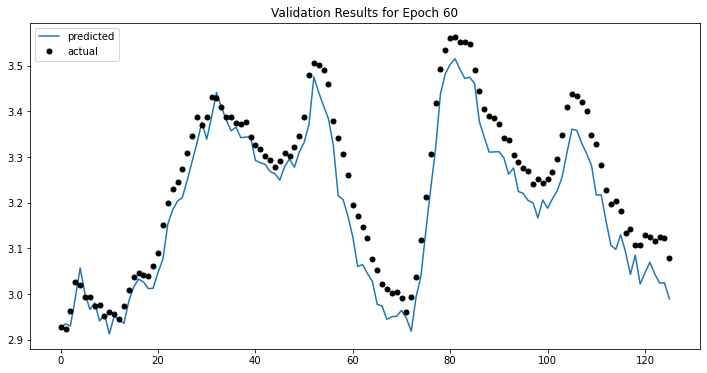

EarlyStopping counter: 24 out of 50
Iter:  61 train:  0.013638462491856285 val:  0.022157662417849264 LR:  0.001
EarlyStopping counter: 25 out of 50
Iter:  62 train:  0.013468004396745795 val:  0.024766356615181867 LR:  0.001
EarlyStopping counter: 26 out of 50
Iter:  63 train:  0.01361443347418915 val:  0.028269213047603426 LR:  0.001
EarlyStopping counter: 27 out of 50
Iter:  64 train:  0.0133829187001801 val:  0.02577500271931566 LR:  0.001
EarlyStopping counter: 28 out of 50
Iter:  65 train:  0.013515437483061048 val:  0.027613605977316488 LR:  0.001
EarlyStopping counter: 29 out of 50
Iter:  66 train:  0.013774011545308398 val:  0.029085151996475055 LR:  0.001
EarlyStopping counter: 30 out of 50
Iter:  67 train:  0.013438179394963922 val:  0.027326083206728177 LR:  0.001
EarlyStopping counter: 31 out of 50
Iter:  68 train:  0.013729432185677093 val:  0.026813456018061645 LR:  0.001
EarlyStopping counter: 32 out of 50
Iter:  69 train:  0.013619927384173874 val:  0.02546790930631687

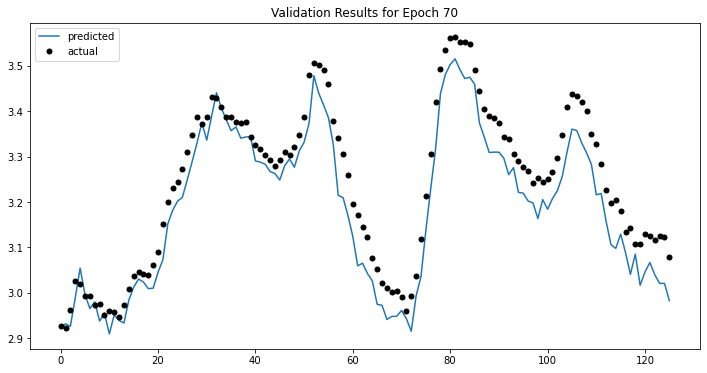

EarlyStopping counter: 34 out of 50
Iter:  71 train:  0.01323480080101067 val:  0.025373936765171662 LR:  0.0001
EarlyStopping counter: 35 out of 50
Iter:  72 train:  0.013191389389515236 val:  0.025160561680660328 LR:  0.0001
EarlyStopping counter: 36 out of 50
Iter:  73 train:  0.01320940509836761 val:  0.025841097247360778 LR:  0.0001
EarlyStopping counter: 37 out of 50
Iter:  74 train:  0.013247100418910793 val:  0.0264419525732863 LR:  0.0001
EarlyStopping counter: 38 out of 50
Iter:  75 train:  0.013212942113975631 val:  0.02452724059626895 LR:  0.0001
EarlyStopping counter: 39 out of 50
Iter:  76 train:  0.013213816084486449 val:  0.02594496880404615 LR:  0.0001
EarlyStopping counter: 40 out of 50
Iter:  77 train:  0.013247086997857883 val:  0.02582894953995174 LR:  0.0001
EarlyStopping counter: 41 out of 50
Iter:  78 train:  0.013233996525704719 val:  0.025933455289429582 LR:  0.0001
EarlyStopping counter: 42 out of 50
Iter:  79 train:  0.013229775428512747 val:  0.025984794882

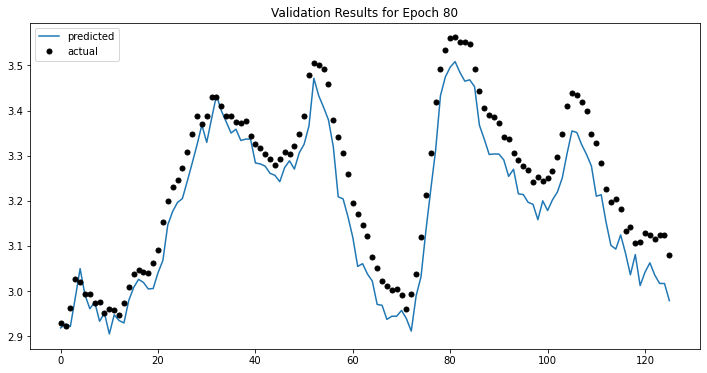

EarlyStopping counter: 44 out of 50
Iter:  81 train:  0.013231341855007963 val:  0.023402915240929988 LR:  0.0001
EarlyStopping counter: 45 out of 50
Iter:  82 train:  0.013175139957734049 val:  0.02608975319827874 LR:  0.0001
EarlyStopping counter: 46 out of 50
Iter:  83 train:  0.013200299275115034 val:  0.02525289852872596 LR:  0.0001
EarlyStopping counter: 47 out of 50
Iter:  84 train:  0.013221634925864926 val:  0.022529154651547336 LR:  0.0001
EarlyStopping counter: 48 out of 50
Iter:  85 train:  0.013218707924663554 val:  0.02499811527355005 LR:  1e-05
EarlyStopping counter: 49 out of 50
Iter:  86 train:  0.013147285564188064 val:  0.024852360422330036 LR:  1e-05
EarlyStopping counter: 50 out of 50
Early stopping


In [56]:
nn_train(model=darnn, 
         model_name=model_name, 
         epochs=max_epochs, 
         data_train_loader=data_train_loader, 
         data_val_loader=data_val_loader, 
         opt=darnn_opt, 
         scheduler=darnn_scheduler,
         target_scaler=target_scaler,
         plot=True)

### Evaluation

In [57]:
darnn.load_state_dict(torch.load(f"{model_name}.pt"))

<All keys matched successfully>

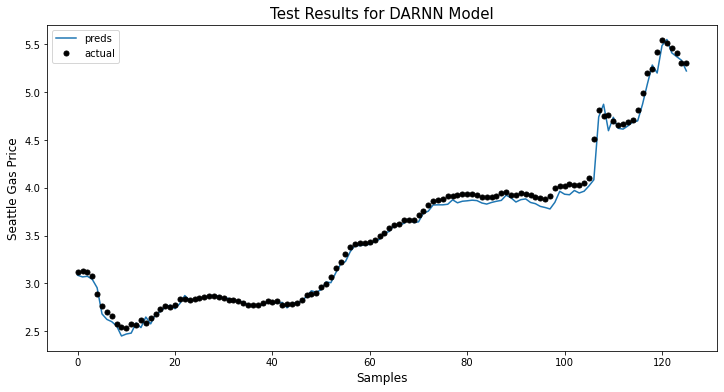

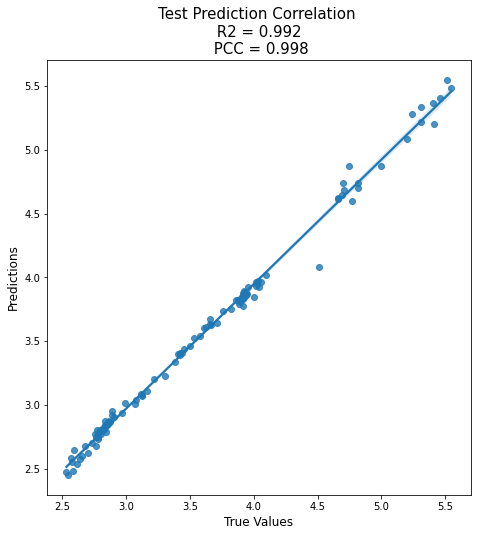

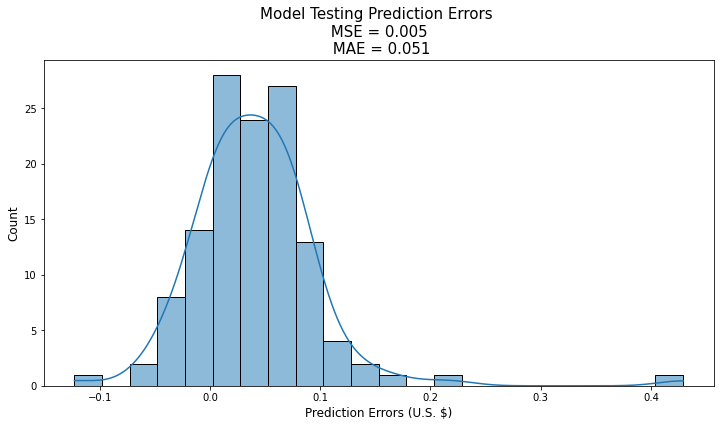

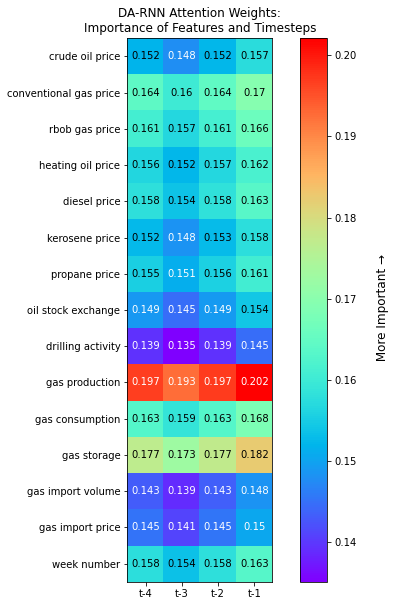

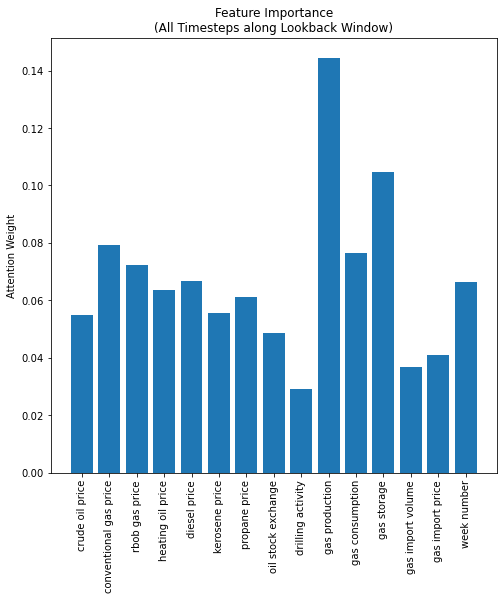

In [69]:
darnn_mse, darnn_mae, darnn_r2, darnn_pcc, darnn_preds, darnn_true, darnn_alphas, darnn_betas = nn_eval(model=darnn, 
                                                                             model_name='darnn', 
                                                                             data_test_loader=data_test_loader, 
                                                                             target_scaler=target_scaler)

### Forecasting

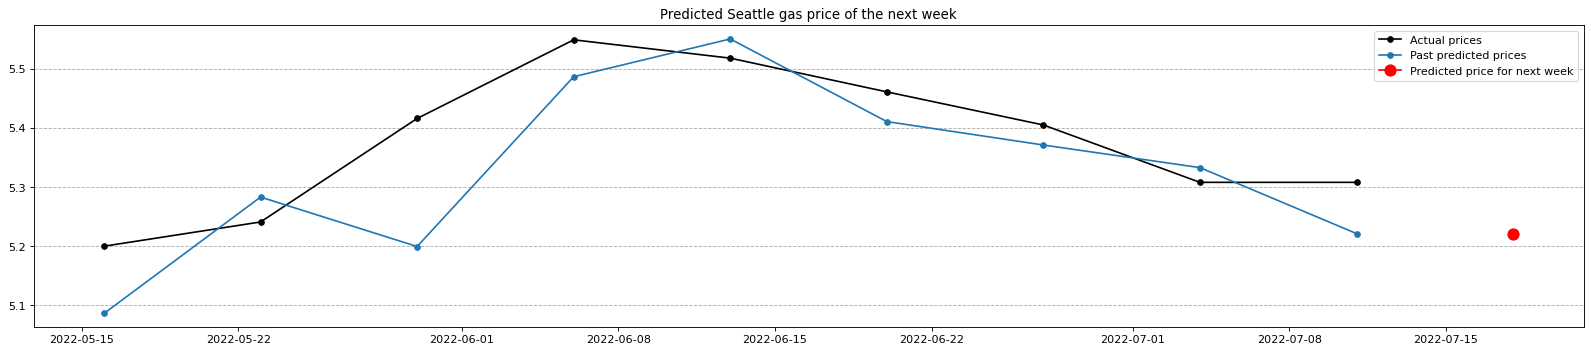

DARNN Predicted Seattle Gas Price of the next week: $5.22


In [59]:
nn_forecast(model = darnn,
            model_name = 'darnn', 
            data = features_targets, 
            timesteps = timesteps, 
            n_timeseries = n_timeseries, 
            true = darnn_true, 
            preds = darnn_preds,
            x_scaler = x_scaler, 
            y_his_scaler = y_his_scaler, 
            target_scaler = target_scaler, 
            plot_range=10
           )

## 6e. Hierarchical Attention-Based Recurrent Highway Network (HARHN)

### Training

In [60]:
harhn = HARHN(n_conv_layers=3, 
              T=timesteps, 
              in_feats=n_timeseries, 
              target_feats=1, 
              n_units_enc=harhn_n_enc_units, 
              n_units_dec=harhn_n_dec_units, 
              device=device
             ).to(device)
model_name = 'harhn'
harhn_opt = torch.optim.AdamW(harhn.parameters(), lr=0.01)
harhn_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=harhn_opt, patience=15)

Validation loss decreased (inf --> 0.021599).  Saving model ...
Iter:  0 train:  0.2751562612698869 val:  0.1469661912591032 LR:  0.01
mse:  0.14388347 mae:  0.35657117


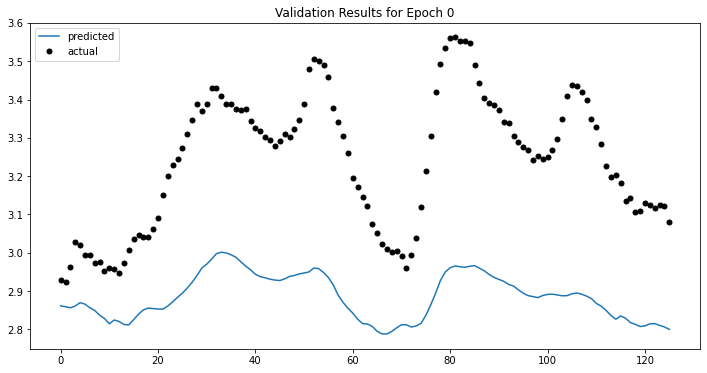

Validation loss decreased (0.021599 --> 0.012384).  Saving model ...
Iter:  1 train:  0.10819307349828378 val:  0.11128200897355389 LR:  0.01
Validation loss decreased (0.012384 --> 0.007175).  Saving model ...
Iter:  2 train:  0.05051178475793595 val:  0.0847050258289725 LR:  0.01
Validation loss decreased (0.007175 --> 0.001170).  Saving model ...
Iter:  3 train:  0.028435028746274748 val:  0.0341982749862759 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  4 train:  0.023292311065260404 val:  0.04488055384333541 LR:  0.01
Validation loss decreased (0.001170 --> 0.000392).  Saving model ...
Iter:  5 train:  0.030170184576581455 val:  0.019806954821779486 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  6 train:  0.021659819694659792 val:  0.02837139748888664 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  7 train:  0.021463962332644804 val:  0.020027157265222428 LR:  0.01
Validation loss decreased (0.000392 --> 0.000312).  Saving model ...
Iter:  8 train:  0.018770273700227

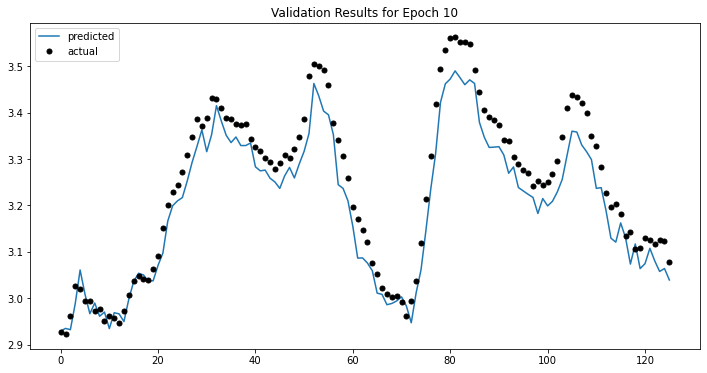

EarlyStopping counter: 3 out of 50
Iter:  11 train:  0.02708247984695232 val:  0.032724891485168314 LR:  0.01
EarlyStopping counter: 4 out of 50
Iter:  12 train:  0.017982756981068552 val:  0.03431723074970156 LR:  0.01
Validation loss decreased (0.000312 --> 0.000177).  Saving model ...
Iter:  13 train:  0.019054004779251867 val:  0.013285364336470443 LR:  0.01
Validation loss decreased (0.000177 --> 0.000101).  Saving model ...
Iter:  14 train:  0.018780422170877366 val:  0.010027381618647366 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  15 train:  0.018602801837856585 val:  0.014266580826229988 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  16 train:  0.01855202873085114 val:  0.014189113453676816 LR:  0.01
EarlyStopping counter: 3 out of 50
Iter:  17 train:  0.01679327117512564 val:  0.029454886389385402 LR:  0.01
EarlyStopping counter: 4 out of 50
Iter:  18 train:  0.02307602989729554 val:  0.053577329786247505 LR:  0.01
EarlyStopping counter: 5 out of 50
Iter:  19 trai

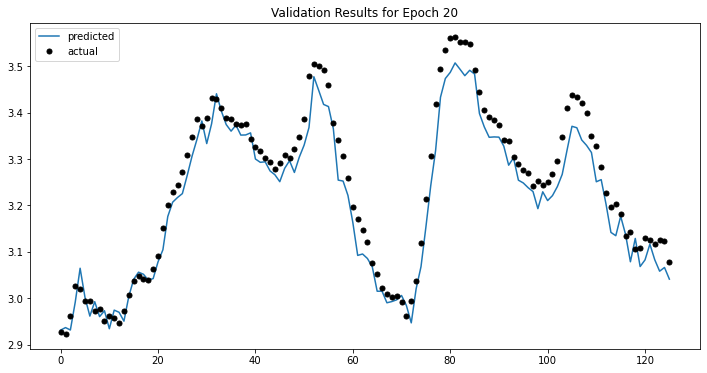

EarlyStopping counter: 7 out of 50
Iter:  21 train:  0.020683168418685772 val:  0.034438259234114005 LR:  0.01
EarlyStopping counter: 8 out of 50
Iter:  22 train:  0.020547129566016967 val:  0.02376872180226507 LR:  0.01
EarlyStopping counter: 9 out of 50
Iter:  23 train:  0.015942972692060853 val:  0.022654720661050613 LR:  0.01
EarlyStopping counter: 10 out of 50
Iter:  24 train:  0.017270447669761067 val:  0.02448979542958358 LR:  0.01
EarlyStopping counter: 11 out of 50
Iter:  25 train:  0.017678727553135355 val:  0.017042029608991007 LR:  0.01
EarlyStopping counter: 12 out of 50
Iter:  26 train:  0.02107130236515116 val:  0.02472698511518643 LR:  0.01
EarlyStopping counter: 13 out of 50
Iter:  27 train:  0.016486788211745762 val:  0.03206345736290863 LR:  0.01
EarlyStopping counter: 14 out of 50
Iter:  28 train:  0.019126388710086976 val:  0.03734472179479274 LR:  0.01
EarlyStopping counter: 15 out of 50
Iter:  29 train:  0.021098741377237894 val:  0.012557192581106949 LR:  0.01
E

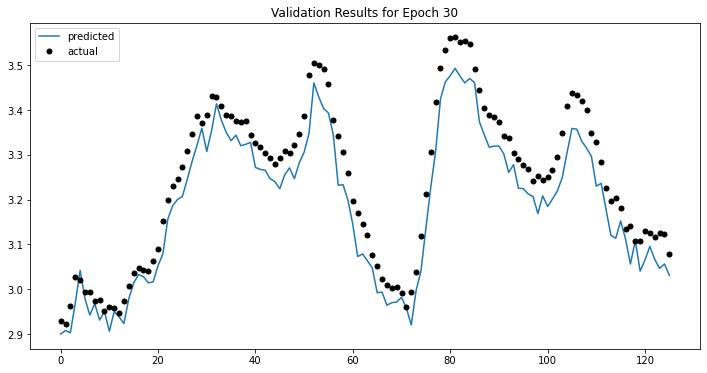

EarlyStopping counter: 17 out of 50
Iter:  31 train:  0.01476147172614775 val:  0.01888322432970122 LR:  0.001
EarlyStopping counter: 18 out of 50
Iter:  32 train:  0.014444545970524561 val:  0.01707874539718821 LR:  0.001
EarlyStopping counter: 19 out of 50
Iter:  33 train:  0.014466908614343273 val:  0.02121611599137198 LR:  0.001
EarlyStopping counter: 20 out of 50
Iter:  34 train:  0.01449093075063414 val:  0.022061610781277753 LR:  0.001
EarlyStopping counter: 21 out of 50
Iter:  35 train:  0.014244514450754366 val:  0.01098092538579552 LR:  0.001
EarlyStopping counter: 22 out of 50
Iter:  36 train:  0.014726314800810734 val:  0.01791754687120005 LR:  0.001
EarlyStopping counter: 23 out of 50
Iter:  37 train:  0.01435734834855435 val:  0.015272174519678654 LR:  0.001
EarlyStopping counter: 24 out of 50
Iter:  38 train:  0.014526248730326444 val:  0.01885985344664945 LR:  0.001
EarlyStopping counter: 25 out of 50
Iter:  39 train:  0.014297945078205051 val:  0.02337256257157356 LR: 

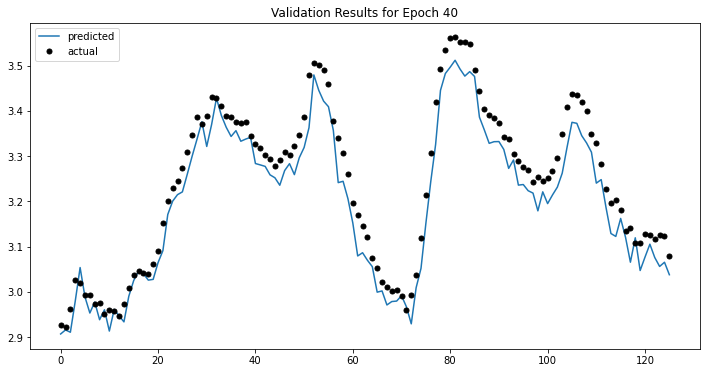

EarlyStopping counter: 27 out of 50
Iter:  41 train:  0.014738479308976647 val:  0.012807305657141952 LR:  0.001
EarlyStopping counter: 28 out of 50
Iter:  42 train:  0.014918050023358864 val:  0.0206103250209452 LR:  0.001
EarlyStopping counter: 29 out of 50
Iter:  43 train:  0.014164321091110979 val:  0.02085797938964563 LR:  0.001
EarlyStopping counter: 30 out of 50
Iter:  44 train:  0.014342532045487976 val:  0.01642789715339688 LR:  0.001
EarlyStopping counter: 31 out of 50
Iter:  45 train:  0.014949796842834975 val:  0.019797750843345785 LR:  0.001
EarlyStopping counter: 32 out of 50
Iter:  46 train:  0.01431423783276802 val:  0.022966398305558626 LR:  0.0001
EarlyStopping counter: 33 out of 50
Iter:  47 train:  0.014174258449528342 val:  0.01879460423563952 LR:  0.0001
EarlyStopping counter: 34 out of 50
Iter:  48 train:  0.0139450683147005 val:  0.01841525870531263 LR:  0.0001
EarlyStopping counter: 35 out of 50
Iter:  49 train:  0.013924377143340187 val:  0.01889947176343245 L

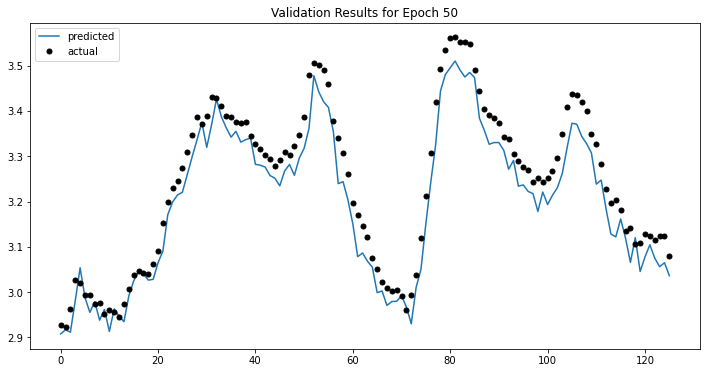

EarlyStopping counter: 37 out of 50
Iter:  51 train:  0.013968656119839962 val:  0.02066124396967532 LR:  0.0001
EarlyStopping counter: 38 out of 50
Iter:  52 train:  0.014010330119630179 val:  0.01954009922591229 LR:  0.0001
EarlyStopping counter: 39 out of 50
Iter:  53 train:  0.013905131451770419 val:  0.016871637344285453 LR:  0.0001
EarlyStopping counter: 40 out of 50
Iter:  54 train:  0.013910805031812572 val:  0.020746262410764958 LR:  0.0001
EarlyStopping counter: 41 out of 50
Iter:  55 train:  0.01397128060635216 val:  0.019938745364681716 LR:  0.0001
EarlyStopping counter: 42 out of 50
Iter:  56 train:  0.013962251924437872 val:  0.018654705383893314 LR:  0.0001
EarlyStopping counter: 43 out of 50
Iter:  57 train:  0.01394404136065063 val:  0.018435162486608536 LR:  0.0001
EarlyStopping counter: 44 out of 50
Iter:  58 train:  0.013943890876100418 val:  0.019955631752084056 LR:  0.0001
EarlyStopping counter: 45 out of 50
Iter:  59 train:  0.013960888344078054 val:  0.018453458

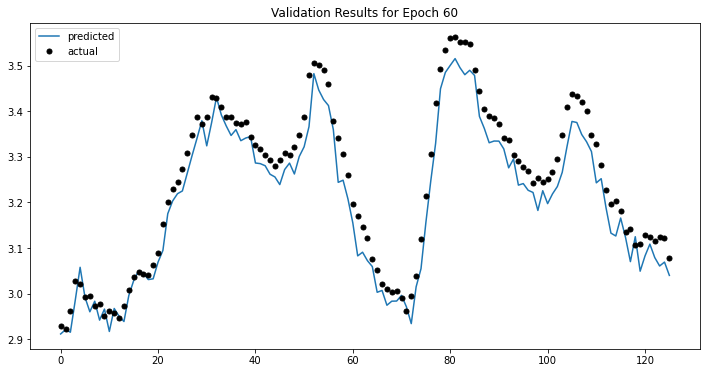

EarlyStopping counter: 47 out of 50
Iter:  61 train:  0.01394652449235957 val:  0.01983050334816264 LR:  0.0001
EarlyStopping counter: 48 out of 50
Iter:  62 train:  0.013896153684391788 val:  0.017794172871674188 LR:  1e-05
EarlyStopping counter: 49 out of 50
Iter:  63 train:  0.013910507763887157 val:  0.018407321496207198 LR:  1e-05
EarlyStopping counter: 50 out of 50
Early stopping


In [61]:
nn_train(model=harhn, 
         model_name=model_name, 
         epochs=max_epochs, 
         data_train_loader=data_train_loader, 
         data_val_loader=data_val_loader, 
         opt=harhn_opt, 
         scheduler=harhn_scheduler,
         target_scaler=target_scaler,
         plot=True)

### Evaluation

In [62]:
harhn.load_state_dict(torch.load(f"{model_name}.pt"))

<All keys matched successfully>

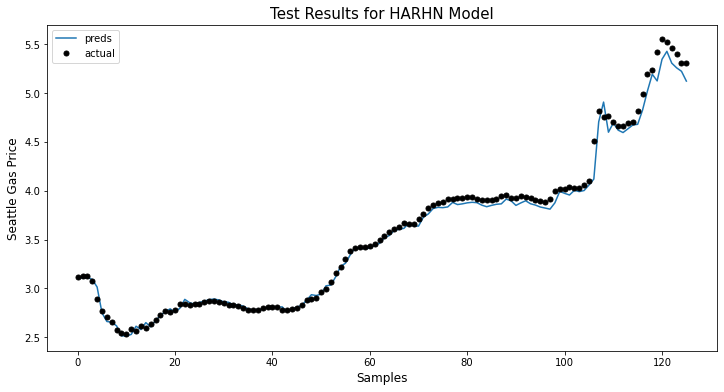

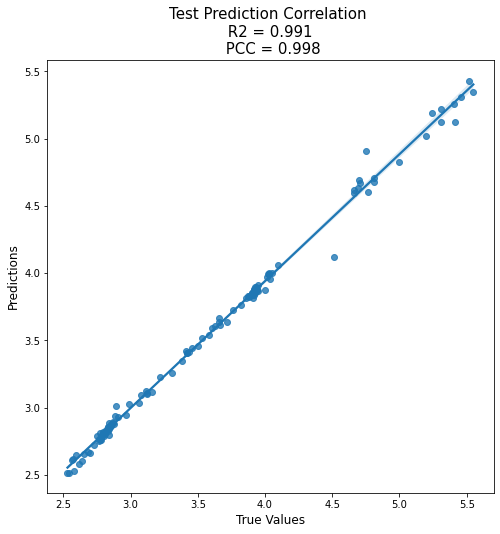

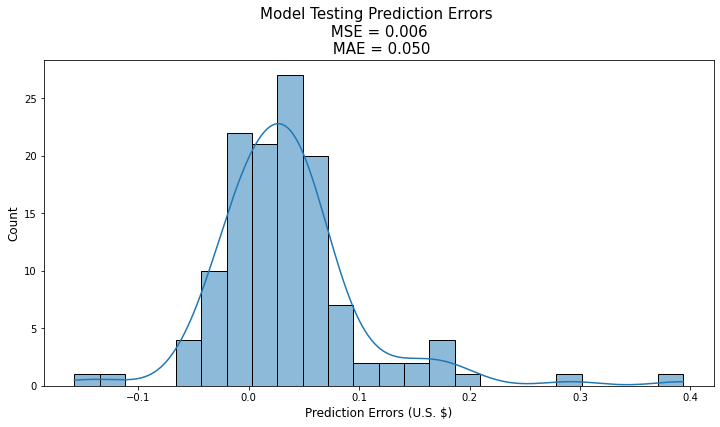

In [63]:
harhn_mse, harhn_mae, harhn_r2, harhn_pcc, harhn_preds, harhn_true, _, _ = nn_eval(model=harhn, 
                                                                             model_name='harhn', 
                                                                             data_test_loader=data_test_loader, 
                                                                             target_scaler=target_scaler)

### Forecast

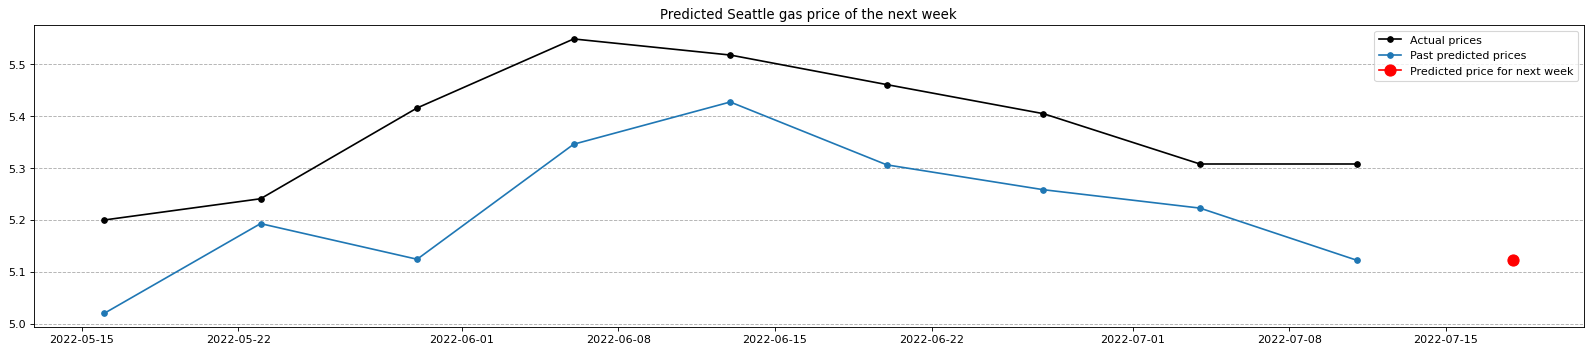

HARHN Predicted Seattle Gas Price of the next week: $5.12


In [64]:
nn_forecast(model = harhn,
            model_name = 'harhn', 
            data = features_targets, 
            timesteps = timesteps, 
            n_timeseries = n_timeseries, 
            true = harhn_true, 
            preds = harhn_preds,
            x_scaler = x_scaler, 
            y_his_scaler = y_his_scaler, 
            target_scaler = target_scaler, 
            plot_range=10
           )

# 7. Model Comparison

In [95]:
model_names = ['Prophet', 'Neural Prophet', 'LSTM', 'DA-RNN', 'HRHN']

df=pd.DataFrame({"Root Mean Square Err.":[prophet_mse**0.5, nprophet_mse**0.5, lstm_mse**0.5, darnn_mse**0.5, harhn_mse**0.5],
                 "Mean Absolute Err.":[prophet_mae, nprophet_mae, lstm_mae, darnn_mae, harhn_mae], 
                 "R2 Score": [prophet_r2, nprophet_r2, lstm_r2, darnn_r2, harhn_r2], 
                 "Pearson Corr. Coeff.": [prophet_pcc, nprophet_pcc, lstm_pcc, darnn_pcc, harhn_pcc]
                })
df = df.round(decimals=3)
df.index = model_names

df = df.style.highlight_max(
    subset = ['R2 Score', 'Pearson Corr. Coeff.'],
    color = 'lightgreen', axis = 0).highlight_min(
    subset = ['Root Mean Square Err.', 'Mean Absolute Err.'],
    color = 'lightgreen', axis = 0)

In [96]:
df

,Root Mean Square Err.,Mean Absolute Err.,R2 Score,Pearson Corr. Coeff.
Prophet,0.650000,0.517000,0.220000,0.518000
Neural Prophet,0.699000,0.577000,0.099000,0.719000
LSTM,0.350000,0.263000,0.811000,0.964000
DA-RNN,0.072000,0.051000,0.992000,0.998000
HRHN,0.076000,0.050000,0.991000,0.998000
